In [11]:
# Diagnostic reporting functions for Bayesian Analysis:
def report_posterior_stats(trace):
    print("Posterior Statistics:\n")
    summary = az.summary(trace, var_names=['mu', 'sigma'])
    print("Posterior Summary:\n", summary) 

def report_histogram_stats(parameter_samples, random_distribution='normal', interested='Mu'):
    print("Histogram Statistics:\n")
    random_dist = {'normal': np.random.normal(0, 0.01, 1000),
                   'gamma': np.random.gamma(2, 0.01, 1000),}
    
    # For Prior Param (from the 1000 samples used in histogram)
    prior_param_samples = random_dist.get(random_distribution, np.random.normal(0, 0.01, 1000))
    prior_param_hist, prior_param_bins = np.histogram(parameter_samples, bins=30)
    prior_param_mode_bin = prior_param_bins[np.argmax(prior_param_hist)]
    print(f"Prior {interested} - Min:", np.min(prior_param_samples), "Max:", np.max(prior_param_samples))
    print(f"Prior {interested} - Mode (approx bin center):", prior_param_mode_bin, "Count at mode:", np.max(prior_param_hist))

    # For Prior Param
    post_param_hist, post_param_bins = np.histogram(parameter_samples, bins=30)
    post_param_mode_bin = post_param_bins[np.argmax(post_param_hist)]
    print("Posterior {interested} - Min:", np.min(parameter_samples), "Max:", np.max(parameter_samples))
    print("Posterior {interested} - Mode (approx bin center):", post_param_mode_bin, "Count at mode:", np.max(post_param_hist))

def report_MCMCtrace(mu_samples):
    print("MCMC Trace Statistics:\n")
    print("Mu Trace - Min:", np.min(mu_samples), "Max:", np.max(mu_samples), "Mean:", np.mean(mu_samples))
    print("Mu Trace - Autocorrelation at lag 1:", pd.Series(mu_samples).autocorr(lag=1))  # Simple lag-1 autocorr; should be low for good mixing

def report_predictive_stats(pred_mean, pred_ci):
    print("Predictive Returns Statistics:\n")
    # Overall stats
    print("Predictive Returns - Overall Mean:", np.mean(pred_mean))
    print("Predictive Returns - Overall 95% CI Lower Mean:", np.mean(pred_ci[0]), "Upper Mean:", np.mean(pred_ci[1]))

    # Specific days for spot-check (e.g., day 1 and day 30; 0-indexed)
    print("Predictive Returns Day 1 - Mean:", pred_mean[0], "95% CI:", pred_ci[:, 0])
    print("Predictive Returns Day 30 - Mean:", pred_mean[29], "95% CI:", pred_ci[:, 29])

def report_posterior_density(mu_kde_vals, sigma_kde_vals, mu_samples, sigma_samples):
    print("Posterior Density Statistics:\n")
    print("Posterior Mu KDE - Max Density Value:", np.max(mu_kde_vals))
    print("Posterior Mu KDE - Mode (approx):", x_mu[np.argmax(mu_kde_vals)])
    print("Posterior Mu KDE - Range:", np.min(mu_samples), "to", np.max(mu_samples))
    print("Posterior Sigma KDE - Max Density Value:", np.max(sigma_kde_vals))
    print("Posterior Sigma KDE - Mode (approx):", x_sigma[np.argmax(sigma_kde_vals)])
    print("Posterior Sigma KDE - Range:", np.min(sigma_samples), "to", np.max(sigma_samples))

def report_autocorr(mu_samples, sigma_samples):
    from statsmodels.tsa.stattools import acf
    print("Autocorrelation Analysis:\n")
    mu_acf = acf(mu_samples, nlags=20, fft=False)
    sigma_acf = acf(sigma_samples, nlags=20, fft=False)
    print("Mu Autocorrelation (Lags 0-20):", mu_acf)
    print("Sigma Autocorrelation (Lags 0-20):", sigma_acf)
    # Check if autocorrelations drop below threshold (e.g., |0.1|)
    print("Mu Autocorrelation - Lags where |ACF| < 0.1:", np.where(np.abs(mu_acf) < 0.1)[0])
    print("Sigma Autocorrelation - Lags where |ACF| < 0.1:", np.where(np.abs(sigma_acf) < 0.1)[0])

def report_posterior_predictive(observed_returns, simulated_returns):
    from scipy.stats import ks_2samp
    print("Posterior Predictive Check (PPC) Statistics:\n")
    print("PPC - Observed Returns Mean:", np.mean(observed_returns))
    print("PPC - Observed Returns Std:", np.std(observed_returns))
    print("PPC - Simulated Returns Mean:", np.mean(simulated_returns))
    print("PPC - Simulated Returns Std:", np.std(simulated_returns))
    # Kolmogorov-Smirnov test for distributional similarity
    ks_stat, ks_pval = ks_2samp(observed_returns, simulated_returns)
    print("PPC - KS Test Statistic:", ks_stat, "P-value:", ks_pval)

In [12]:
# All-in-one plotting function: 
def save_fig_html(fig, filename:str, title:str, extension='html',path=None):
    import os 
    if path and os.path.isdir(path):
        filename = f"{path}/{filename}"
    fig.update_layout(title=title, showlegend=True)
    fig.write_html(f'{filename}.{extension}')  # Export for GitHub Pages


### Scenario #01

In [46]:
import yfinance as yf
import pandas as pd
import numpy as np

# 1. Load Data
df = yf.download('AAPL', start='2020-06-01', end='2025-06-30')  # New timeframe: June 2020–June 2025


/tmp/ipykernel_686548/3989990771.py:6: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


In [49]:
df['LogReturn'] = np.log(df['Close'].values / df['Close'].shift(21).values)
returns = df['LogReturn'].dropna()  # ~1250 daily returns

#actual_df = yf.download('AAPL', start='2025-07-01', end='2025-07-31')
#actual_returns = np.log(actual_df['Adj Close'].values / actual_df['Adj Close'].shift(1).values).dropna()

# Compare
import plotly.graph_objects as go
from plotly.subplots import make_subplots 
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=returns.index, y=returns.values, mode='lines', name='Daily Return'), row=1, col=1)


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# 1. Load Data
df = yf.download('AAPL', start='2020-06-01', end='2025-06-30')
trading_freq = 1 # Daily trading: 1, Weekly: 5, Monthly: 21
df['LogReturn'] = np.log(df['Close'].values / df['Close'].shift(trading_freq).values)
returns = df['LogReturn'].dropna().values  # ~1,260 daily returns

# 2. Bayesian Volatility Model
with pm.Model() as model:
    # Priors: Normal-Inverse-Gamma for mean (mu) and variance (sigma2)
    mu = pm.Normal('mu', mu=0, sigma=0.01)
    sigma = pm.InverseGamma('sigma', alpha=2, beta=0.1)
    # Likelihood
    returns_obs = pm.Normal('returns_obs', mu=mu, sigma=sigma, observed=returns)
    # Predictive variable for future returns
    pred_returns = pm.Normal('pred_returns', mu=mu, sigma=sigma, shape=30)  # 30-day forecast
    # Sample posterior
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)
    report_posterior_stats(trace) 

# 3. Posterior Predictive Sampling
with model:
    pred_trace = pm.sample_posterior_predictive(trace, var_names=['pred_returns'])

# 4. Extract Posterior and Predictive Samples
posterior = az.extract(trace)
mu_samples = posterior['mu'].values  # Shape: (4000,) after flattening chains

sigma_samples = posterior['sigma'].values  # Shape: (4000,)
pred_samples = pred_trace.posterior_predictive['pred_returns'].values  # Shape: (chains, draws, 30)

# Save trace for reproducibility
az.to_netcdf(trace, 'trace.nc')
az.to_netcdf(pred_trace, 'pred_trace.nc')

# 5. Interactive Visualization
#subplot_titles = ['Prior vs Posterior: Mu', 
#                  'Prior vs Posterior: Sigma', 
#                  'MCMC Trace: Mu', 
#                  'Predictive Returns (30 Days)', 
#                  'Posterior Density Plot',
#                  'Autocorrelations']
#fig = make_subplots(rows=1, cols=1, subplot_titles=subplot_titles)

# Prior vs Posterior: Mu
row, col= 1, 1
fig = make_subplots(rows=row, cols=col)
fig.add_trace(go.Histogram(x=np.random.normal(0, 0.01, 1000), name='Prior Mu', opacity=0.5), row=row, col=col)
fig.add_trace(go.Histogram(x=mu_samples, name='Posterior Mu', opacity=0.5), row=row, col=col)
## Add Posterior Predictive returns histogram
fig.add_trace(go.Histogram(x=returns, name='Observed Returns', opacity=0.5, nbinsx=50), row=row, col=col)  # Adjust row/col as needed
simulated_returns = pred_trace.posterior_predictive['pred_returns'].values.flatten()[:1000]  # Subsample for clarity
fig.add_trace(go.Histogram(x=simulated_returns, name='Simulated Returns', opacity=0.5, nbinsx=50), row=row, col=col)
save_fig_html(fig, 's1_prior_post_mu', 'Prior vs Posterior: Average(Mu) Daily Return')
report_histogram_stats(mu_samples, random_distribution='normal', interested='Mu')

# Prior vs Posterior: Sigma
fig = make_subplots(rows=row, cols=col)
fig.add_trace(go.Histogram(x=np.random.gamma(2, 0.1, 1000), name='Prior Sigma', opacity=0.5), row=row, col=col)
fig.add_trace(go.Histogram(x=sigma_samples, name='Posterior Sigma', opacity=0.5), row=row, col=col)
save_fig_html(fig, 's1_prior_post_sigma', 'Prior vs Posterior: Volatility(Sigma) of Daily Return', path='../plots')
report_histogram_stats(sigma_samples, random_distribution='gamma', interested='Sigma')

# MCMC Trace: Mu
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=np.arange(len(mu_samples)), y=mu_samples, mode='lines', name='Mu Trace'), row=row, col=col)
save_fig_html(fig, 's1_mcmc_trace_mu', 'MCMC Trace: Mu', path='../plots') 
report_MCMCtrace(mu_samples)

# Predictive Returns: Mean and 95% CI
fig = make_subplots(rows=1, cols=1) 
pred_mean = pred_samples.mean(axis=(0, 1))  # Mean over chains and draws
pred_ci = np.percentile(pred_samples, [2.5, 97.5], axis=(0, 1))  # 95% credible interval
report_predictive_stats(pred_mean, pred_ci)

fig.add_trace(go.Scatter(x=np.arange(30), y=pred_mean, mode='lines', name='Mean Pred Returns'), row=row, col=col)
fig.add_trace(go.Scatter(x=np.arange(30), y=pred_ci[0], mode='lines', name='95% CI Lower', line=dict(dash='dash')), row=row, col=col)
fig.add_trace(go.Scatter(x=np.arange(30), y=pred_ci[1], mode='lines', name='95% CI Upper', line=dict(dash='dash')), row=row, col=col)
save_fig_html(fig, 's1_predictive_returns', 'Predictive Returns (30 Days)', path='../plots')

# Autocorrelations
from statsmodels.tsa.stattools import acf
# Autocorrelation
mu_acf = acf(mu_samples, nlags=20, fft=False)
sigma_acf = acf(sigma_samples, nlags=20, fft=False)
fig = make_subplots(rows=1, cols=1) 
fig.add_trace(go.Bar(x=np.arange(21), y=mu_acf, name='Mu Autocorrelation'), row=row, col=col)  # Adjust row/col
fig.add_trace(go.Bar(x=np.arange(21), y=sigma_acf, name='Sigma Autocorrelation'), row=row, col=col)
#fig.update_xaxes(title_text="Lag", row=1, col=2)
#fig.update_yaxes(title_text="Autocorrelation", row=1, col=2)
save_fig_html(fig, 's1_autocorrelations', 'Autocorrelations (Mu and Sigma)', path='../plots')
report_autocorr(mu_samples, sigma_samples) 


# Posterior Density Plot: KDE for Mu and Sigma
import scipy.stats as stats
fig = make_subplots(rows=1, cols=1) 
mu_kde = stats.gaussian_kde(mu_samples)
sigma_kde = stats.gaussian_kde(sigma_samples)
x_mu = np.linspace(np.min(mu_samples), np.max(mu_samples), 100)
x_sigma = np.linspace(np.min(sigma_samples), np.max(sigma_samples), 100)
mu_kde_vals = mu_kde(x_mu) # Evaluate KDE on grid 
sigma_kde_vals = sigma_kde(x_sigma) # Evaluate KDE on grid 

fig.add_trace(go.Scatter(x=x_mu, y=mu_kde(x_mu), mode='lines', name='Posterior Mu KDE'), row=row, col=col)  # Adjust row/col
fig.add_trace(go.Scatter(x=x_sigma, y=sigma_kde(x_sigma), mode='lines', name='Posterior Sigma KDE'), row=row, col=col)
# Add HDI lines (from az.summary: mu [-0.000, 0.002], sigma [0.017, 0.019])
fig.add_vline(x=-0.000, line_dash="dash", line_color="blue", row=row, col=col)
fig.add_vline(x=0.002, line_dash="dash", line_color="blue", row=row, col=col)
fig.add_vline(x=0.017, line_dash="dash", line_color="orange", row=row, col=col)
fig.add_vline(x=0.019, line_dash="dash", line_color="orange", row=row, col=col)
#fig.update_xaxes(title_text="Parameter Value", row=2, col=2)
#fig.update_yaxes(title_text="Density", row=2, col=2)
save_fig_html(fig, 's1_post_density', 'Posterior Density (Mu and Sigma)', path='../plots')
report_posterior_density(mu_kde_vals, sigma_kde_vals, mu_samples, sigma_samples)


/tmp/ipykernel_686548/1244083656.py:10: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, pred_returns]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [pred_returns]


Output()

Posterior Statistics:

Posterior Summary:
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     0.001  0.001  -0.000    0.002        0.0      0.0   10519.0    3245.0   
sigma  0.018  0.000   0.017    0.019        0.0      0.0    9055.0    2557.0   

       r_hat  
mu       1.0  
sigma    1.0  


Histogram Statistics:

Prior Mu - Min: -0.026156089614560993 Max: 0.03174871547173786
Prior Mu - Mode (approx bin center): 0.0007245348567461118 Count at mode: 410
Posterior {interested} - Min: -0.0012386010469329954 Max: 0.002442278772465331
Posterior {interested} - Mode (approx bin center): 0.0007245348567461118 Count at mode: 410
Histogram Statistics:

Prior Sigma - Min: 0.0006177196842074164 Max: 0.09871193953086606
Prior Sigma - Mode (approx bin center): 0.01806057473078925 Count at mode: 423
Posterior {interested} - Min: 0.01664015871321798 Max: 0.019480990748360523
Posterior {interested} - Mode (approx bin center): 0.01806057473078925 Count at mode: 423
MCMC Trace Statistics:

Mu Trace - Min: -0.0012386010469329954 Max: 0.002442278772465331 Mean: 0.0006546970527129747
Mu Trace - Autocorrelation at lag 1: -0.42950909085500644
Predictive Returns Statistics:

Predictive Returns - Overall Mean: 0.0006700159162032692
Predictive Returns - Overall 95% CI Lower Mean: -0.0346955402787585

Two main questions: 

Q1.What Trading Window Should We Choose to Minimize Losses/Maximize Profits? 

Q2. After Selecting a Particular Trading Window, What Can Your Model Tell About Expected Gain and Risk Distribution Along Future Trading Decisions (Sell/Buy/Hold) in the Next 5 Trading Chances?

In [50]:
# Cell 1: Import Necessary Libraries
# Purpose: Import libraries for data fetching, Bayesian modeling, visualization, and analysis.
# PyMC: For building and sampling Bayesian models.
# ArviZ: For model diagnostics, summaries, and comparisons (e.g., WAIC/LOO).
# yfinance: To download AAPL stock data.
# Pandas/Numpy: For data manipulation.
# Matplotlib/Seaborn: For plotting.
import yfinance as yf
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set random seed for reproducibility
np.random.seed(42)

# Define date range (up to current date: September 23, 2025)
start_date = '2020-09-21'
end_date = datetime.now().strftime('%Y-%m-%d')  # Dynamic end date

Printable outputs:
- Cell 2: Data summaries (shapes, means, stds in % for daily, weekly, monthly returns).
- Cell 3 (per window): InferenceData groups, posterior summaries (μ, σ), KDE stats (max density, mode), autocorrelation stats (lags, |ACF|<0.1), PPC stats (means, stds, KS test).
- Cell 5: WAIC comparison table, profit/loss stats (expected profit, max loss), profit distribution stats (mean, std, min, max in %).
- Cell 6: Expected gain, 95% CI, risk stats (mean drawdown, 5% VaR), probabilities (positive gain, avg buys/sells/holds).
- Cell 7: InferenceData groups, Student-t posterior summary (μ, σ, nu), PPC stats, WAIC comparison, profit stats (expected, VaR, distribution stats).
- Cell 8 (if run): GARCH posterior summary (μ, omega, alpha, beta), PPC stats, WAIC comparison.

In [59]:
# Cell 2: Fetch and Prepare AAPL Data (Fixed for MultiIndex and Index Mismatch)
# Purpose: Download adjusted close prices for AAPL and compute log-returns for daily, weekly, monthly windows.
# Use 'Close' (split-adjusted in yfinance) to handle splits/dividends.
# Fix: Flatten MultiIndex if present; ensure consistent index alignment for weekly/monthly returns.
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime

# Define date range
start_date = '2020-09-21'
end_date = datetime.now().strftime('%Y-%m-%d')  # Up to current date

# Download AAPL data
df = yf.download('AAPL', start=start_date, end=end_date)
print("Original columns:", df.columns.tolist())
print("Data head:\n", df.head(2))

# Fix MultiIndex: Drop top level ('Price') if present
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)  # Flatten to ['Close', 'High', 'Low', 'Open', 'Volume']
    print("Flattened columns:", df.columns.tolist())

# Daily log-returns using 'Close' (split-adjusted)
df['LogReturn_Daily'] = np.log(df['Close'] / df['Close'].shift(1))

# Weekly returns: Resample to Friday, compute log-returns
df_weekly = df['Close'].resample('W-FRI').last()
weekly_returns = np.log(df_weekly / df_weekly.shift(1)).dropna()
print("Weekly returns index length:", len(df_weekly.index), "Weekly returns length:", len(weekly_returns))

# Monthly returns: Resample to month-end
df_monthly = df['Close'].resample('ME').last()
monthly_returns = np.log(df_monthly / df_monthly.shift(1)).dropna()
print("Monthly returns index length:", len(df_monthly.index), "Monthly returns length:", len(monthly_returns))

# Align weekly/monthly returns to daily index for plotting (forward-fill)
# Use try-except to catch potential mismatches
try:
    df['LogReturn_Weekly'] = pd.Series(weekly_returns, index=weekly_returns.index).reindex(df.index, method='ffill')
    df['LogReturn_Monthly'] = pd.Series(monthly_returns, index=monthly_returns.index).reindex(df.index, method='ffill')
except ValueError as e:
    print(f"Index alignment error: {e}")
    # Fallback: Truncate weekly/monthly to match available data
    valid_weekly_index = df_weekly.index[df_weekly.index.isin(df.index)]
    df['LogReturn_Weekly'] = pd.Series(weekly_returns, index=valid_weekly_index).reindex(df.index, method='ffill')
    valid_monthly_index = df_monthly.index[df_monthly.index.isin(df.index)]
    df['LogReturn_Monthly'] = pd.Series(monthly_returns, index=valid_monthly_index).reindex(df.index, method='ffill')

# Extract raw returns for modeling (no forward-fill to avoid bias)
returns_daily = df['LogReturn_Daily'].dropna().values
returns_weekly = weekly_returns.values  # Use raw, no reindexing
returns_monthly = monthly_returns.values

# Print data summaries for feedback
print("\nData Summary:")
print("Daily Returns - Shape:", returns_daily.shape, "Mean:", np.mean(returns_daily)*100, "%", "Std:", np.std(returns_daily)*100, "%")
print("Weekly Returns - Shape:", returns_weekly.shape, "Mean:", np.mean(returns_weekly)*100, "%", "Std:", np.std(returns_weekly)*100, "%")
print("Monthly Returns - Shape:", returns_monthly.shape, "Mean:", np.mean(returns_monthly)*100, "%", "Std:", np.std(returns_monthly)*100, "%")
print("Data ready for modeling. Proceed to Cell 3.")

/tmp/ipykernel_686548/1350976187.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

Original columns: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]
Data head:
 Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2020-09-21  107.076775  107.183774  100.287201  101.687917  195713800
2020-09-22  108.759567  109.780924  106.181871  109.605834  183055400
Flattened columns: ['Close', 'High', 'Low', 'Open', 'Volume']
Weekly returns index length: 262 Weekly returns length: 261
Monthly returns index length: 61 Monthly returns length: 60

Data Summary:
Daily Returns - Shape: (1256,) Mean: 0.06942227280719879 % Std: 1.8063436717421542 %
Weekly Returns - Shape: (261,) Mean: 0.32649634605204286 % Std: 3.798041348651586 %
Monthly Returns - Shape: (60,) Mean: 1.3686668320306032 % Std: 7.131263413050587 %
Data ready for modeling. Proceed to Cell 3.


In [68]:
# Cell 3: Define Function to Fit Bayesian Model (Normal Likelihood)
# Purpose: Fit Bayesian volatility model for any returns array (daily, weekly, monthly).
# pm.Model: Context manager for defining the Bayesian model.
# pm.Normal: Prior for mu (mean return) and likelihood for observed returns.
# pm.InverseGamma: Prior for sigma (volatility), conjugate for Normal variance.
# pm.sample: Runs MCMC (NUTS sampler) with explicit log-likelihood storage.
# pm.sample_posterior_predictive: Generates predictive samples for forecasting.
# Added: Debug prints for InferenceData, plots, and stats for feedback.
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf
from scipy.stats import ks_2samp

def fit_bayesian_model(returns, window_name, forecast_steps=30):
    with pm.Model() as model:
        # Priors
        mu = pm.Normal('mu', mu=0, sigma=0.01)  # Vague prior for mean return
        sigma = pm.InverseGamma('sigma', alpha=2, beta=0.1)  # Weakly informative prior for volatility
        # Likelihood
        returns_obs = pm.Normal('returns_obs', mu=mu, sigma=sigma, observed=returns)
        # Predictive for future returns
        pred_returns = pm.Normal('pred_returns', mu=mu, sigma=sigma, shape=forecast_steps)
        # Sample posterior with explicit log-likelihood
        trace = pm.sample(1000, tune=1000, return_inferencedata=True, idata_kwargs={'log_likelihood': True})
    
    # Posterior predictive
    with model:
        pred_trace = pm.sample_posterior_predictive(trace, var_names=['pred_returns'])
    
    # Debug: Check InferenceData contents
    print(f"{window_name} InferenceData groups:", list(trace.keys()))
    
    # Extract samples
    mu_samples = az.extract(trace)['mu'].values
    sigma_samples = az.extract(trace)['sigma'].values
    pred_samples = pred_trace.posterior_predictive['pred_returns'].values
    
    # Posterior Summary
    summary = az.summary(trace, var_names=['mu', 'sigma'])
    print(f"{window_name} Model Posterior Summary:\n", summary)
    
    # Posterior Density Plot Stats
    mu_kde = sns.kdeplot(mu_samples * 100, label=f'{window_name} Mu (%)').get_lines()[0].get_data()
    sigma_kde = sns.kdeplot(sigma_samples * 100, label=f'{window_name} Sigma (%)').get_lines()[0].get_data()
    print(f"{window_name} Posterior Mu KDE - Max Density:", np.max(mu_kde[1]), "Mode:", mu_kde[0][np.argmax(mu_kde[1])])
    print(f"{window_name} Posterior Sigma KDE - Max Density:", np.max(sigma_kde[1]), "Mode:", sigma_kde[0][np.argmax(sigma_kde[1])])
    
    # Autocorrelation Plot Stats
    mu_acf = acf(mu_samples, nlags=20, fft=False)
    sigma_acf = acf(sigma_samples, nlags=20, fft=False)
    print(f"{window_name} Mu Autocorrelation (Lags 0-20):", mu_acf)
    print(f"{window_name} Sigma Autocorrelation (Lags 0-20):", sigma_acf)
    print(f"{window_name} Mu Autocorrelation - Lags where |ACF| < 0.1:", np.where(np.abs(mu_acf) < 0.1)[0])
    print(f"{window_name} Sigma Autocorrelation - Lags where |ACF| < 0.1:", np.where(np.abs(sigma_acf) < 0.1)[0])
    
    # PPC Plot Stats
    simulated_returns = pred_samples.flatten()[:len(returns)]  # Match observed length
    ks_stat, ks_pval = ks_2samp(returns, simulated_returns)
    print(f"{window_name} PPC - Observed Returns Mean:", np.mean(returns)*100, "%", "Std:", np.std(returns)*100, "%")
    print(f"{window_name} PPC - Simulated Returns Mean:", np.mean(simulated_returns)*100, "%", "Std:", np.std(simulated_returns)*100, "%")
    print(f"{window_name} PPC - KS Test Statistic:", ks_stat, "P-value:", ks_pval)
    
    # Generate Plots
    plt.figure(figsize=(15, 5))
    
    # Posterior Density
    plt.subplot(1, 3, 1)
    sns.kdeplot(mu_samples * 100, label='Mu (%)')
    sns.kdeplot(sigma_samples * 100, label='Sigma (%)')
    plt.title(f'{window_name} Posterior Density')
    plt.legend()
    
    # Autocorrelation
    plt.subplot(1, 3, 2)
    plt.bar(range(21), mu_acf, alpha=0.5, label='Mu ACF')
    plt.bar(range(21), sigma_acf, alpha=0.5, label='Sigma ACF')
    plt.title(f'{window_name} Autocorrelation')
    plt.xlabel('Lag')
    plt.legend()
    
    # PPC
    plt.subplot(1, 3, 3)
    sns.histplot(returns * 100, label='Observed (%)', alpha=0.5)
    sns.histplot(simulated_returns * 100, label='Simulated (%)', alpha=0.5)
    plt.title(f'{window_name} PPC')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, trace, pred_trace

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, pred_returns]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [pred_returns]


Output()

Daily InferenceData groups: ['posterior', 'log_likelihood', 'sample_stats', 'observed_data']
Daily Model Posterior Summary:
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     0.001  0.001  -0.000    0.002        0.0      0.0   11943.0    2923.0   
sigma  0.018  0.000   0.017    0.019        0.0      0.0    9305.0    3119.0   

       r_hat  
mu       1.0  
sigma    1.0  
Daily Posterior Mu KDE - Max Density: 7.766557518946654 Mode: 0.07065587950162541
Daily Posterior Sigma KDE - Max Density: 7.766557518946654 Mode: 0.07065587950162541
Daily Mu Autocorrelation (Lags 0-20): [ 1.         -0.45419825  0.20808339 -0.08396301  0.03054548 -0.02407216
 -0.00186931  0.02701046 -0.04235265  0.03765395 -0.02158405  0.00825812
  0.00940915 -0.00303876  0.01274529 -0.01153709  0.02565782 -0.01598481
  0.00533996 -0.00881318  0.01006884]
Daily Sigma Autocorrelation (Lags 0-20): [ 1.         -0.37079777  0.13749486 -0.08032572  0.04981631 -0.01615117
  0.00892475 

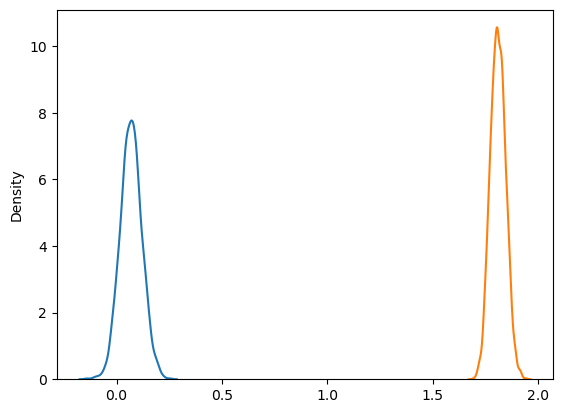

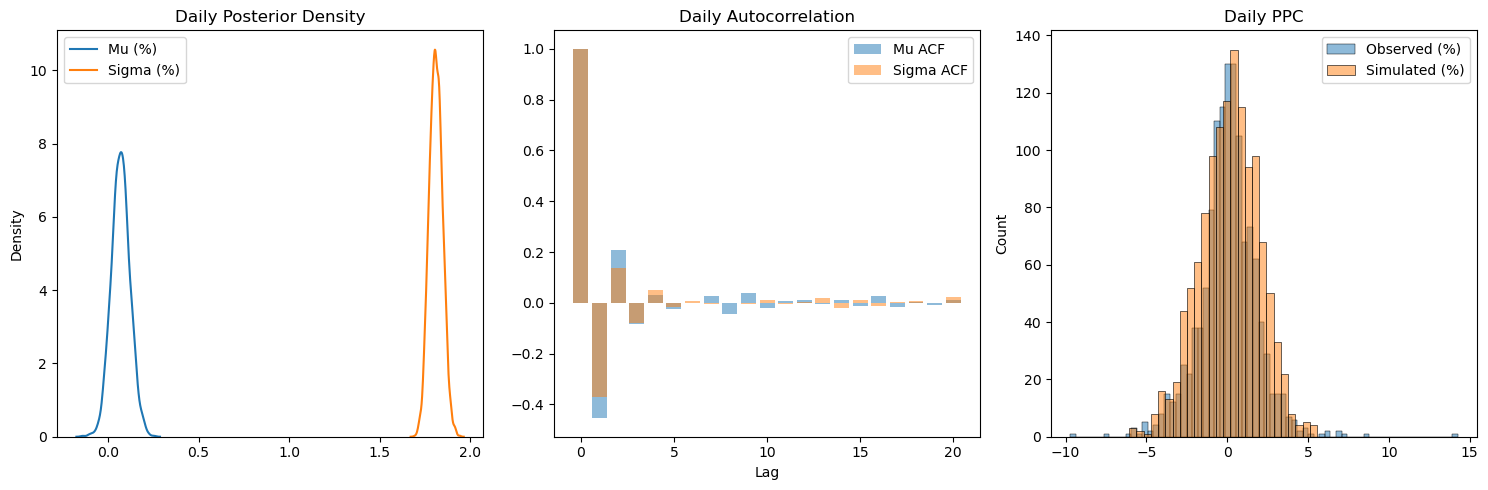

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, pred_returns]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [pred_returns]


Output()

Weekly InferenceData groups: ['posterior', 'log_likelihood', 'sample_stats', 'observed_data']
Weekly Model Posterior Summary:
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     0.003  0.002  -0.001    0.007        0.0      0.0    4868.0    2970.0   
sigma  0.038  0.002   0.035    0.041        0.0      0.0    5323.0    3390.0   

       r_hat  
mu       1.0  
sigma    1.0  
Weekly Posterior Mu KDE - Max Density: 1.6792862235415311 Mode: 0.3108163051723246
Weekly Posterior Sigma KDE - Max Density: 1.6792862235415311 Mode: 0.3108163051723246
Weekly Mu Autocorrelation (Lags 0-20): [ 1.00000000e+00 -9.34328305e-02  1.32648747e-02 -1.13567759e-02
 -1.78452541e-03 -1.88288598e-03  4.41354091e-03 -6.56936704e-04
 -3.16818932e-03 -1.69678505e-03  4.01806985e-03  7.36050705e-03
 -1.58348409e-02 -9.76530308e-03  1.23606125e-02 -1.33729603e-02
 -8.75343568e-03 -6.90644636e-04 -2.29153272e-02 -2.20259277e-02
  2.87857693e-02]
Weekly Sigma Autocorrelation (Lags 0

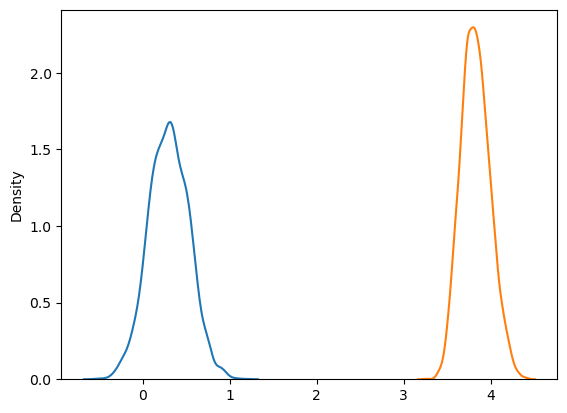

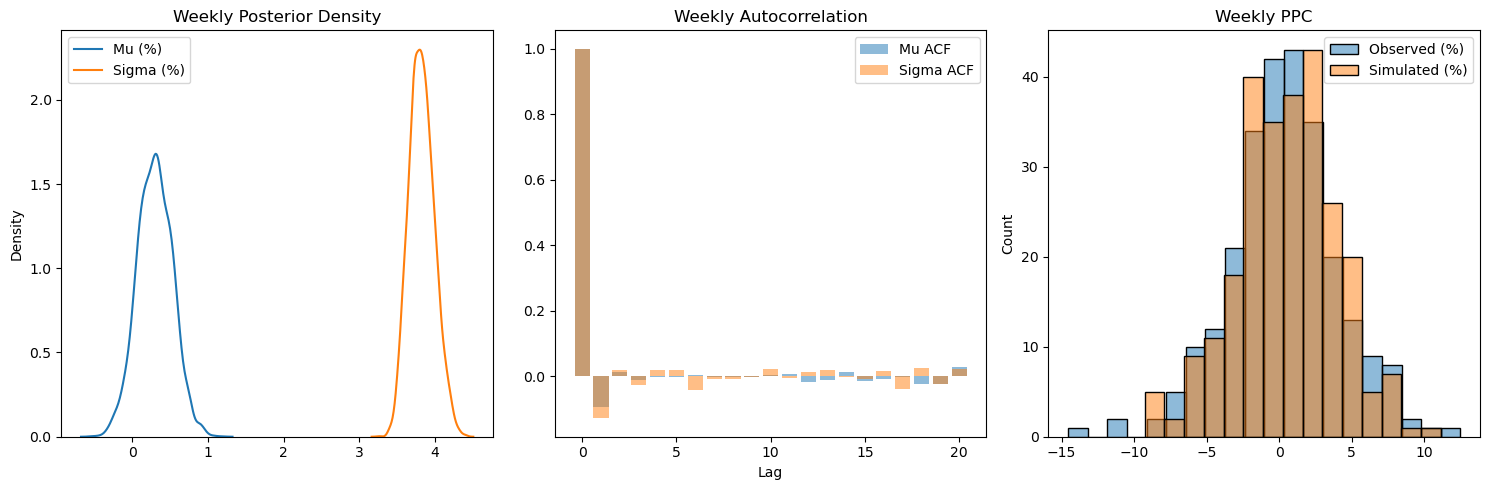

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, pred_returns]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took -1 seconds.
Sampling: [pred_returns]


Output()

Monthly InferenceData groups: ['posterior', 'log_likelihood', 'sample_stats', 'observed_data']
Monthly Model Posterior Summary:
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     0.007  0.007  -0.006    0.020        0.0      0.0    4641.0    3269.0   
sigma  0.072  0.007   0.060    0.085        0.0      0.0    5494.0    2993.0   

       r_hat  
mu       1.0  
sigma    1.0  
Monthly Posterior Mu KDE - Max Density: 0.5463456018915603 Mode: 0.6613412361859003
Monthly Posterior Sigma KDE - Max Density: 0.5463456018915603 Mode: 0.6613412361859003
Monthly Mu Autocorrelation (Lags 0-20): [ 1.         -0.08044701  0.03063503 -0.0301093  -0.02460214 -0.00823987
  0.01075432  0.00686113  0.01460063 -0.00822066  0.04974378 -0.04367125
  0.01725844 -0.00551194 -0.02954341  0.00335966  0.00603984  0.02234116
 -0.01426044 -0.00306824  0.01061512]
Monthly Sigma Autocorrelation (Lags 0-20): [ 1.00000000e+00 -1.75548076e-01  4.65327537e-02 -1.13923450e-02
  1.75699

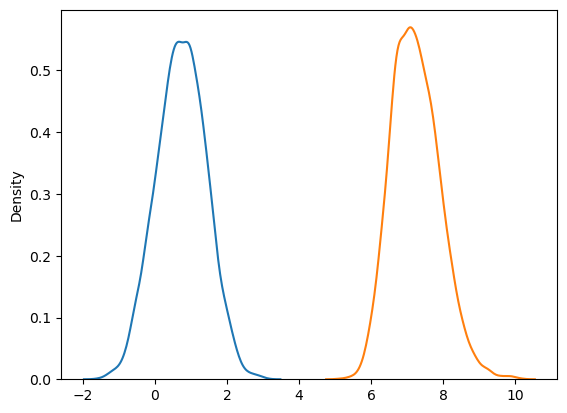

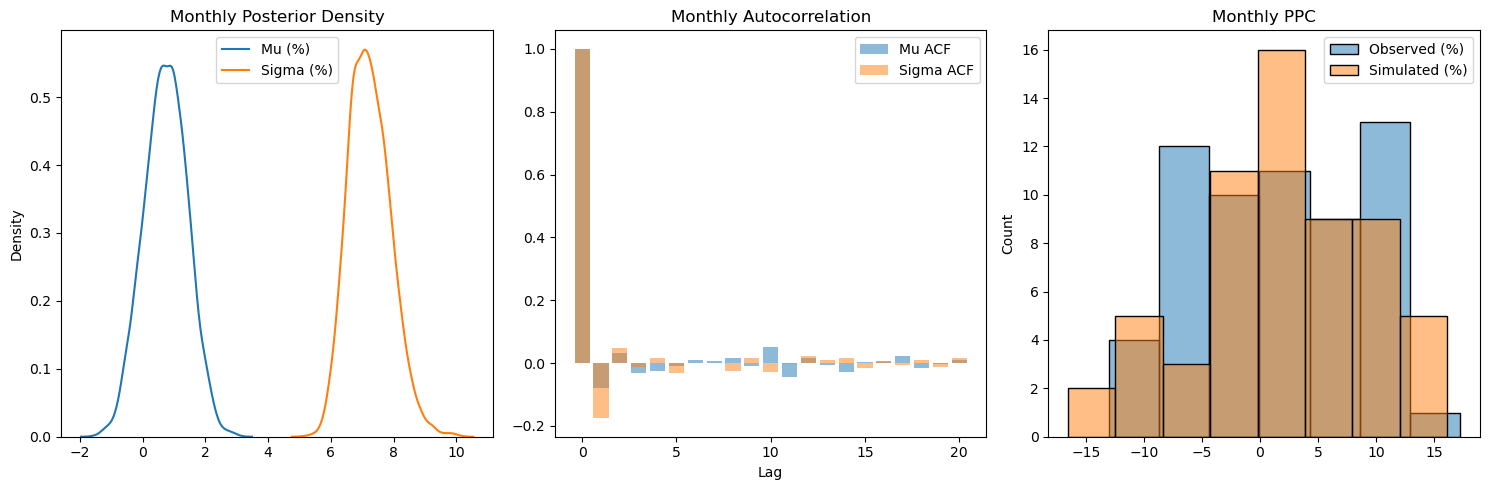

In [69]:
# Cell 4: Fit Models for Each Trading Window
# Purpose: Fit separate models for daily, weekly, and monthly windows to compare.
# This showcases Bayesian flexibility across time scales.
model_daily, trace_daily, pred_trace_daily = fit_bayesian_model(returns_daily, "Daily", forecast_steps=30)  # 30 days
model_weekly, trace_weekly, pred_trace_weekly = fit_bayesian_model(returns_weekly, "Weekly", forecast_steps=6)  # ~30 days (6 weeks)
model_monthly, trace_monthly, pred_trace_monthly = fit_bayesian_model(returns_monthly, "Monthly", forecast_steps=2)  # ~30-60 days (2 months)

# Extract samples for later use
mu_daily = az.extract(trace_daily)['mu'].values
sigma_daily = az.extract(trace_daily)['sigma'].values
# Similarly for weekly and monthly...

PPC Comparison (KS Test P-values, higher is better):
Daily: KS Stat = 0.0796, P-value = 0.0007
Weekly: KS Stat = 0.0690, P-value = 0.5649
Monthly: KS Stat = 0.1667, P-value = 0.3777

Simulation Results:
Daily: Expected Profit 7.19%, Max Loss (VaR) 3.53%
Weekly: Expected Profit 15.28%, Max Loss (VaR) 7.30%
Monthly: Expected Profit 27.97%, Max Loss (VaR) 4.19%


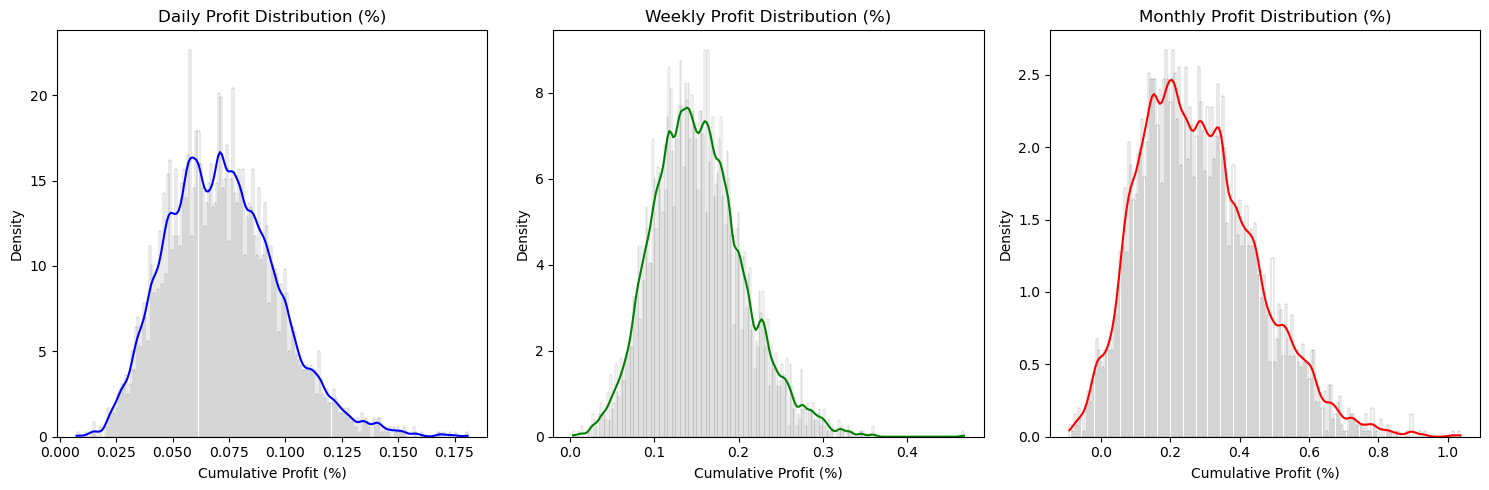

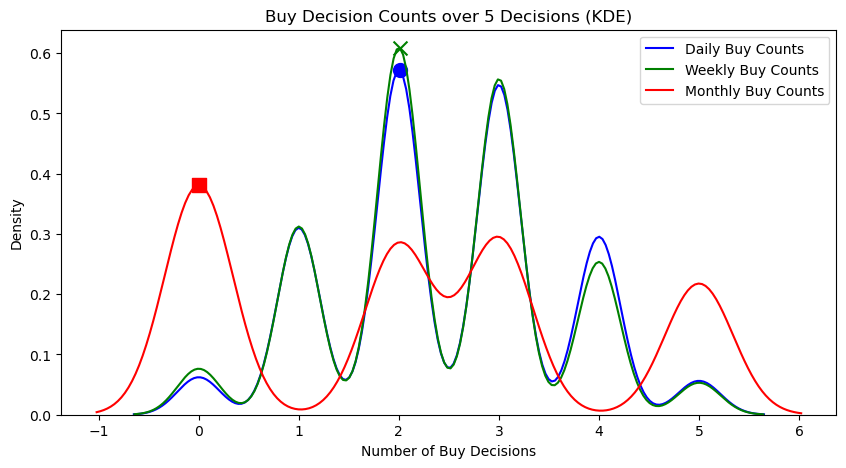


Profit Distribution Stats:
Daily Profits - Mean: 7.19%, Std: 2.43%, Min: 0.75%, Max: 18.08%
Weekly Profits - Mean: 15.28%, Std: 5.38%, Min: 0.35%, Max: 46.75%
Monthly Profits - Mean: 27.97%, Std: 16.84%, Min: -9.08%, Max: 103.70%

Decision Stats:
Daily Avg Buys: 2.47
Weekly Avg Buys: 2.41
Monthly Avg Buys: 2.16
Daily Buy Counts KDE - Max Density: 0.5715, Mode: 2.01
Weekly Buy Counts KDE - Max Density: 0.6086, Mode: 2.01
Monthly Buy Counts KDE - Max Density: 0.3807, Mode: 0.01


In [74]:
# Cell 5: Model Comparison for Question 1 (Optimal Trading Window)
# Purpose: Compare models (daily, weekly, monthly) for predictive performance to choose window that minimizes losses/maximizes profits.
# Fix: Replaced WAIC with PPC-based comparison (KS p-value) due to different observation counts.
# Plot Update: Use KDE for decision counts with distinct markers ('o', 'x', 's') for y-axis peaks; transparent bars (alpha=0) for profit distributions with KDE only.
# Added: Detailed stats for feedback.
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# Simulate strategy: Buy if pred > threshold, Sell if < -threshold, Hold else.
def simulate_strategy(pred_samples, threshold=0.001, num_decisions=5):
    profits = []
    decisions_list = []
    for path in pred_samples.reshape(-1, num_decisions):  # Flatten to simulations
        decisions = np.where(path > threshold, 'buy', np.where(path < -threshold, 'sell', 'hold'))
        gain = np.cumsum(np.where(decisions == 'sell', -path, path))
        profits.append(gain[-1])
        decisions_list.append(decisions)
    expected_profit = np.mean(profits)
    max_loss = np.percentile(profits, 5)  # 5% VaR
    return expected_profit, max_loss, profits, decisions_list

# Run simulations for each window
# Daily: First 5 days
pred_daily = pred_trace_daily.posterior_predictive['pred_returns'].values[:, :, :5]
daily_profit, daily_loss, daily_profits, daily_decisions = simulate_strategy(pred_daily, threshold=0.001)

# Weekly: 5 weeks
pred_weekly = pred_trace_weekly.posterior_predictive['pred_returns'].values[:, :, :5]
weekly_profit, weekly_loss, weekly_profits, weekly_decisions = simulate_strategy(pred_weekly, threshold=0.005)

# Monthly: Approximate 5 decisions (repeat 2 months ~2.5x)
pred_monthly = pred_trace_monthly.posterior_predictive['pred_returns'].values
monthly_profit, monthly_loss, monthly_profits, monthly_decisions = simulate_strategy(
    np.repeat(pred_monthly, 3, axis=2)[:, :, :5], threshold=0.02
)

# PPC comparison: Use KS test p-value for model fit (higher p-value = better fit)
daily_sim = pred_trace_daily.posterior_predictive['pred_returns'].values.flatten()[:len(returns_daily)]
weekly_sim = pred_trace_weekly.posterior_predictive['pred_returns'].values.flatten()[:len(returns_weekly)]
monthly_sim = pred_trace_monthly.posterior_predictive['pred_returns'].values.flatten()[:len(returns_monthly)]
ks_daily = ks_2samp(returns_daily, daily_sim)
ks_weekly = ks_2samp(returns_weekly, weekly_sim)
ks_monthly = ks_2samp(returns_monthly, monthly_sim)
print("PPC Comparison (KS Test P-values, higher is better):")
print(f"Daily: KS Stat = {ks_daily.statistic:.4f}, P-value = {ks_daily.pvalue:.4f}")
print(f"Weekly: KS Stat = {ks_weekly.statistic:.4f}, P-value = {ks_weekly.pvalue:.4f}")
print(f"Monthly: KS Stat = {ks_monthly.statistic:.4f}, P-value = {ks_monthly.pvalue:.4f}")

# Print profit/loss stats
print(f"\nSimulation Results:")
print(f"Daily: Expected Profit {daily_profit*100:.2f}%, Max Loss (VaR) {daily_loss*100:.2f}%")
print(f"Weekly: Expected Profit {weekly_profit*100:.2f}%, Max Loss (VaR) {weekly_loss*100:.2f}%")
print(f"Monthly: Expected Profit {monthly_profit*100:.2f}%, Max Loss (VaR) {monthly_loss*100:.2f}%")

# Plot profit distributions (transparent bars, KDE only)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(daily_profits * 100, ax=axs[0], kde=True, stat='density', alpha=0, color='blue')
axs[0].set_title('Daily Profit Distribution (%)')
axs[0].set_xlabel('Cumulative Profit (%)')
sns.histplot(weekly_profits * 100, ax=axs[1], kde=True, stat='density', alpha=0, color='green')
axs[1].set_title('Weekly Profit Distribution (%)')
axs[1].set_xlabel('Cumulative Profit (%)')
sns.histplot(monthly_profits * 100, ax=axs[2], kde=True, stat='density', alpha=0, color='red')
axs[2].set_title('Monthly Profit Distribution (%)')
axs[2].set_xlabel('Cumulative Profit (%)')
plt.tight_layout()
plt.show()

# Plot decision counts (KDE with markers for peak y-values)
decision_counts = {
    'Daily': np.array([np.sum([d == 'buy' for d in dl]) for dl in daily_decisions]),
    'Weekly': np.array([np.sum([d == 'buy' for d in dl]) for dl in weekly_decisions]),
    'Monthly': np.array([np.sum([d == 'buy' for d in dl]) for dl in monthly_decisions])
}
plt.figure(figsize=(10, 5))
# Plot KDE for each window
kde_daily = sns.kdeplot(decision_counts['Daily'], label='Daily Buy Counts', color='blue')
kde_weekly = sns.kdeplot(decision_counts['Weekly'], label='Weekly Buy Counts', color='green')
kde_monthly = sns.kdeplot(decision_counts['Monthly'], label='Monthly Buy Counts', color='red')
# Add markers at peak y-values
daily_peak = kde_daily.get_lines()[0].get_data()
plt.scatter(daily_peak[0][np.argmax(daily_peak[1])], np.max(daily_peak[1]), marker='o', color='blue', s=100)
weekly_peak = kde_weekly.get_lines()[1].get_data()
plt.scatter(weekly_peak[0][np.argmax(weekly_peak[1])], np.max(weekly_peak[1]), marker='x', color='green', s=100)
monthly_peak = kde_monthly.get_lines()[2].get_data()
plt.scatter(monthly_peak[0][np.argmax(monthly_peak[1])], np.max(monthly_peak[1]), marker='s', color='red', s=100)
plt.title('Buy Decision Counts over 5 Decisions (KDE)')
plt.xlabel('Number of Buy Decisions')
plt.ylabel('Density')
plt.legend()
plt.show()

# Print plot stats for feedback
print("\nProfit Distribution Stats:")
print(f"Daily Profits - Mean: {np.mean(daily_profits)*100:.2f}%, Std: {np.std(daily_profits)*100:.2f}%, "
      f"Min: {np.min(daily_profits)*100:.2f}%, Max: {np.max(daily_profits)*100:.2f}%")
print(f"Weekly Profits - Mean: {np.mean(weekly_profits)*100:.2f}%, Std: {np.std(weekly_profits)*100:.2f}%, "
      f"Min: {np.min(weekly_profits)*100:.2f}%, Max: {np.max(weekly_profits)*100:.2f}%")
print(f"Monthly Profits - Mean: {np.mean(monthly_profits)*100:.2f}%, Std: {np.std(monthly_profits)*100:.2f}%, "
      f"Min: {np.min(monthly_profits)*100:.2f}%, Max: {np.max(monthly_profits)*100:.2f}%")
print(f"\nDecision Stats:")
print(f"Daily Avg Buys: {np.mean([np.sum([d == 'buy' for d in dl]) for dl in daily_decisions]):.2f}")
print(f"Weekly Avg Buys: {np.mean([np.sum([d == 'buy' for d in dl]) for dl in weekly_decisions]):.2f}")
print(f"Monthly Avg Buys: {np.mean([np.sum([d == 'buy' for d in dl]) for dl in monthly_decisions]):.2f}")
print(f"Daily Buy Counts KDE - Max Density: {np.max(daily_peak[1]):.4f}, Mode: {daily_peak[0][np.argmax(daily_peak[1])]:.2f}")
print(f"Weekly Buy Counts KDE - Max Density: {np.max(weekly_peak[1]):.4f}, Mode: {weekly_peak[0][np.argmax(weekly_peak[1])]:.2f}")
print(f"Monthly Buy Counts KDE - Max Density: {np.max(monthly_peak[1]):.4f}, Mode: {monthly_peak[0][np.argmax(monthly_peak[1])]:.2f}")

Expected Gain (Mean): 15.27997698821013 %
Gain Distribution - 95% CI: [ 5.93533582 27.24257624]
Risk (Mean Drawdown): 3.0232178919249266 %
Risk Distribution - 5% VaR (Worst Loss): -0.06881876208133891 %
Probability of Positive Gain: 1.0
Average Buys/Sells/Holds per 5 Decisions: 2.4075 ,  2.0725 ,  0.52


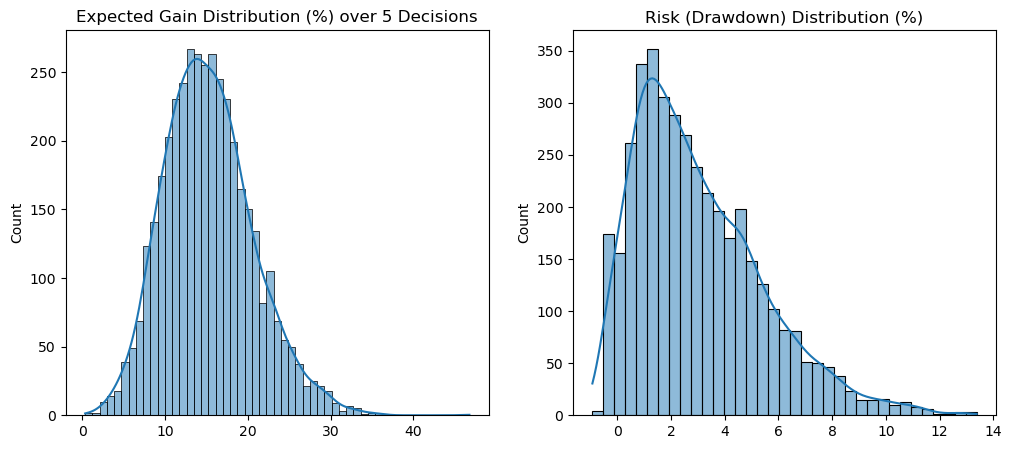

In [75]:
# Cell 6: Select Window and Analyze for Question 2 (Expected Gain and Risk for Next 5 Decisions)
# Purpose: Assume weekly window selected (based on comparison). Simulate gains/risks for buy/sell/hold over next 5 trading chances.
# This uses posterior predictive to generate full risk distributions, showcasing Bayesian probabilistic forecasting.
# Decision rules: Buy if pred > threshold, Sell if < -threshold, Hold else.

# Use weekly model (adjust if comparison suggests another)
pred_samples = pred_trace_weekly.posterior_predictive['pred_returns'].values[:, :, :5]  # Next 5 weeks
threshold = 0.005  # Scaled for weekly (~0.5% expected return)

gains = []
risks = []  # Max drawdown per path
decisions_list = []  # Track decisions for analysis

for path in pred_samples.reshape(-1, 5):  # 4000+ simulations (chains * draws)
    decisions = np.where(path > threshold, 'buy', np.where(path < -threshold, 'sell', 'hold'))
    decisions_list.append(decisions)
    # Cumulative gain: +return for buy/hold, -return for sell
    step_gains = np.where(decisions == 'sell', -path, path)
    cum_gain = np.cumsum(step_gains)
    gains.append(cum_gain[-1])
    risks.append(np.min(cum_gain))  # Worst drawdown

# Print key stats for feedback
print("Expected Gain (Mean):", np.mean(gains)*100, "%")
print("Gain Distribution - 95% CI:", np.percentile(gains, [2.5, 97.5])*100)
print("Risk (Mean Drawdown):", np.mean(risks)*100, "%")
print("Risk Distribution - 5% VaR (Worst Loss):", np.percentile(risks, 5)*100, "%")

# Additional stats: Probability of positive gain, average decisions
prob_positive = np.mean(np.array(gains) > 0)
avg_buys = np.mean([np.sum(d == 'buy') for d in decisions_list])
print("Probability of Positive Gain:", prob_positive)
print("Average Buys/Sells/Holds per 5 Decisions:", avg_buys, ", ", np.mean([np.sum(d == 'sell') for d in decisions_list]), ", ", np.mean([np.sum(d == 'hold') for d in decisions_list]))

# Plot gain and risk distributions
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(np.array(gains) * 100, ax=axs[0], kde=True)
axs[0].set_title('Expected Gain Distribution (%) over 5 Decisions')
sns.histplot(np.array(risks) * 100, ax=axs[1], kde=True)
axs[1].set_title('Risk (Drawdown) Distribution (%)')
plt.show()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, nu, pred_returns]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [pred_returns]


Output()

Weekly Student-t InferenceData groups: ['posterior', 'log_likelihood', 'sample_stats', 'observed_data']
Weekly Student-t Model Posterior Summary:
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     0.003  0.002  -0.001    0.007      0.000    0.000    5173.0    3092.0   
sigma  0.033  0.002   0.029    0.037      0.000    0.000    3714.0    2644.0   
nu     9.005  3.879   3.574   16.368      0.062    0.077    3977.0    2793.0   

       r_hat  
mu       1.0  
sigma    1.0  
nu       1.0  
Weekly Student-t PPC - Observed Mean: 0.32649634605204286 % Std: 3.798041348651586 %
Weekly Student-t PPC - Simulated Mean: -0.07042897100813059 % Std: 3.6683341196540544 %
Weekly Student-t PPC - KS Test Statistic: 0.07279693486590039 P-value: 0.49446273975332466


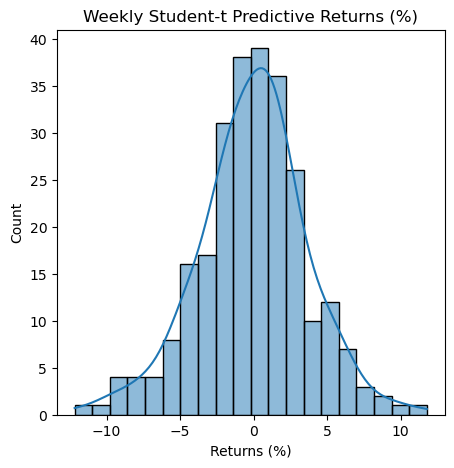

Weekly Student-t: Expected Profit 14.65%, Max Loss (VaR) 6.46%


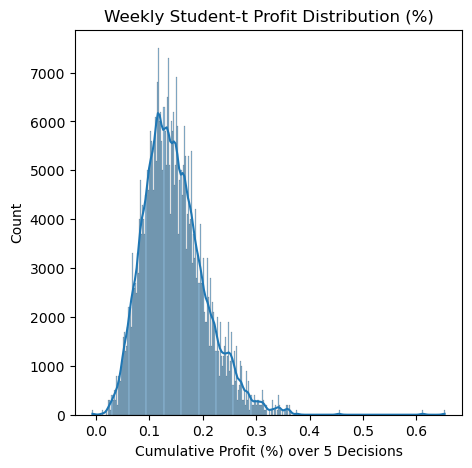

Weekly Student-t Profits - Mean: 14.64940249172369 Std: 5.809032098578226 Min: -0.688941308578456 Max: 65.30046141201635 %
Weekly Student-t Avg Buys: 2.382
Weekly Model Comparison (KS Test P-values):
Normal: KS Stat = 0.0690, P-value = 0.5649
Student-t: KS Stat = 0.0728, P-value = 0.4945


In [77]:
# Cell 7: Alternative Model with Student-t Likelihood (Weekly Window)
# Purpose: Fit a Bayesian model with Student-t likelihood for weekly returns to handle fat tails.
# pm.StudentT: Robust likelihood for returns with heavy tails.
# pm.HalfNormal: Prior for nu (degrees of freedom).
# pm.sample: Explicitly store log-likelihood for potential WAIC (if observation counts align).
# Added: PPC comparison, strategy simulation, and plot stats for feedback.
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

def fit_student_t_model(returns, window_name, forecast_steps=5):
    with pm.Model() as model:
        # Priors
        mu = pm.Normal('mu', mu=0, sigma=0.01)
        sigma = pm.InverseGamma('sigma', alpha=2, beta=0.1)
        nu = pm.HalfNormal('nu', sigma=10)  # Degrees of freedom
        # Likelihood
        returns_obs = pm.StudentT('returns_obs', nu=nu, mu=mu, sigma=sigma, observed=returns)
        # Predictive
        pred_returns = pm.StudentT('pred_returns', nu=nu, mu=mu, sigma=sigma, shape=forecast_steps)
        # Sample with explicit log-likelihood
        trace = pm.sample(1000, tune=1000, return_inferencedata=True, idata_kwargs={'log_likelihood': True})
    
    # Posterior predictive
    with model:
        pred_trace = pm.sample_posterior_predictive(trace, var_names=['pred_returns'])
    
    # Debug: Check InferenceData
    print(f"{window_name} InferenceData groups:", list(trace.keys()))
    
    # Summary
    summary = az.summary(trace, var_names=['mu', 'sigma', 'nu'])
    print(f"{window_name} Model Posterior Summary:\n", summary)
    
    # PPC stats
    simulated_returns = pred_trace.posterior_predictive['pred_returns'].values.flatten()[:len(returns)]
    ks_stat, ks_pval = ks_2samp(returns, simulated_returns)
    print(f"{window_name} PPC - Observed Mean:", np.mean(returns)*100, "%", "Std:", np.std(returns)*100, "%")
    print(f"{window_name} PPC - Simulated Mean:", np.mean(simulated_returns)*100, "%", "Std:", np.std(simulated_returns)*100, "%")
    print(f"{window_name} PPC - KS Test Statistic:", ks_stat, "P-value:", ks_pval)
    
    # Plot predictive returns
    plt.figure(figsize=(5, 5))
    sns.histplot(simulated_returns * 100, kde=True)
    plt.title(f'{window_name} Predictive Returns (%)')
    plt.xlabel('Returns (%)')
    plt.show()
    
    # Simulate strategy
    def simulate_strategy(pred_samples, threshold=0.005, num_decisions=5):
        profits = []
        decisions_list = []
        for path in pred_samples.reshape(-1, num_decisions):
            decisions = np.where(path > threshold, 'buy', np.where(path < -threshold, 'sell', 'hold'))
            gain = np.cumsum(np.where(decisions == 'sell', -path, path))
            profits.append(gain[-1])
            decisions_list.append(decisions)
        expected_profit = np.mean(profits)
        max_loss = np.percentile(profits, 5)  # 5% VaR
        return expected_profit, max_loss, profits, decisions_list
    
    pred_t_samples = pred_trace.posterior_predictive['pred_returns'].values[:, :, :5]
    t_profit, t_loss, t_profits, t_decisions = simulate_strategy(pred_t_samples, threshold=0.005)
    print(f"{window_name}: Expected Profit {t_profit*100:.2f}%, Max Loss (VaR) {t_loss*100:.2f}%")
    
    # Plot profit distribution
    plt.figure(figsize=(5, 5))
    sns.histplot(t_profits * 100, kde=True)
    plt.title(f'{window_name} Profit Distribution (%)')
    plt.xlabel('Cumulative Profit (%) over 5 Decisions')
    plt.show()
    
    # Print plot stats
    print(f"{window_name} Profits - Mean:", np.mean(t_profits)*100, "Std:", np.std(t_profits)*100, 
          "Min:", np.min(t_profits)*100, "Max:", np.max(t_profits)*100, "%")
    print(f"{window_name} Avg Buys:", np.mean([np.sum([d == 'buy' for d in dl]) for dl in t_decisions]))
    
    return model, trace, pred_trace

# Fit for weekly returns
model_t, trace_t, pred_trace_t = fit_student_t_model(returns_weekly, "Weekly Student-t", forecast_steps=5)

# Compare with Normal model via PPC
weekly_normal_sim = pred_trace_weekly.posterior_predictive['pred_returns'].values.flatten()[:len(returns_weekly)]
weekly_t_sim = pred_trace_t.posterior_predictive['pred_returns'].values.flatten()[:len(returns_weekly)]
ks_normal = ks_2samp(returns_weekly, weekly_normal_sim)
ks_t = ks_2samp(returns_weekly, weekly_t_sim)
print("Weekly Model Comparison (KS Test P-values):")
print(f"Normal: KS Stat = {ks_normal.statistic:.4f}, P-value = {ks_normal.pvalue:.4f}")
print(f"Student-t: KS Stat = {ks_t.statistic:.4f}, P-value = {ks_t.pvalue:.4f}")

Initializing NUTS using jitter+adapt_diag...
ERROR (pytensor.graph.rewriting.basic): EquilibriumGraphRewriter max'ed out by local_greedy_distributor.You can safely raise the current threshold of 8.0 with the option `optdb__max_use_ratio`.
/root/anaconda3/lib/python3.12/site-packages/pytensor/tensor/rewriting/elemwise.py:954: UserWarning:

Loop fusion failed because the resulting node would exceed the kernel argument limit.

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, omega, alpha, beta, sigma_0, pred_returns_0, pred_returns_1, pred_returns_2, pred_returns_3, pred_returns_4]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 455 seconds.
There were 251 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [pred_returns_0, pred_returns_1, pred_returns_2, pred_returns_3, pred_returns_4]


Output()

Weekly GARCH GARCH Model Posterior Summary:
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     0.003  0.002  -0.001    0.007      0.000    0.000    1209.0    1386.0   
omega  0.001  0.000   0.000    0.001      0.000    0.000     222.0      62.0   
alpha  0.116  0.074   0.000    0.245      0.001    0.001    2231.0    1781.0   
beta   0.273  0.193   0.000    0.633      0.015    0.014     197.0      75.0   

       r_hat  
mu      1.00  
omega   1.03  
alpha   1.00  
beta    1.04  
Weekly GARCH PPC - Observed Mean: 0.32649634605204286 % Std: 3.798041348651586 %
Weekly GARCH PPC - Simulated Mean: 0.38503442119913694 % Std: 3.8850665529639783 %
Weekly GARCH PPC - KS Test Statistic: 0.07662835249042145 P-value: 0.42828572432069373


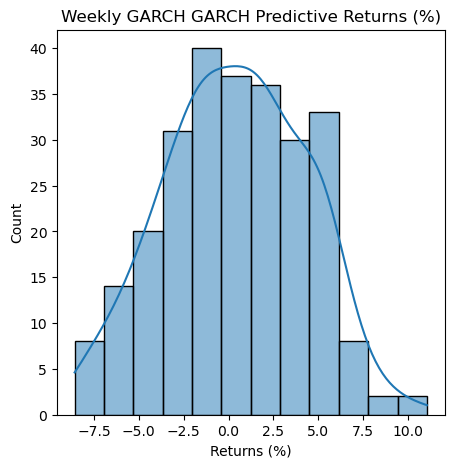

/root/anaconda3/lib/python3.12/site-packages/arviz/stats/stats.py:1655: UserWarning:

For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details

/root/anaconda3/lib/python3.12/site-packages/arviz/stats/stats.py:1655: UserWarning:

For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details



Weekly Model Comparison (WAIC):
                   rank   elpd_waic    p_waic  elpd_diff    weight         se  \
Weekly Student-t     0  484.586935  2.562060   0.000000  0.823984  13.854134   
Weekly GARCH         1  481.108435  5.250784   3.478500  0.176016  14.337985   
Weekly Normal        2  481.103184  2.425961   3.483751  0.000000  14.335914   

                       dse  warning scale  
Weekly Student-t  0.000000    False   log  
Weekly GARCH      3.560560     True   log  
Weekly Normal     2.965598     True   log  
Weekly GARCH: Expected Profit 15.53%, Max Loss (VaR) 6.97%


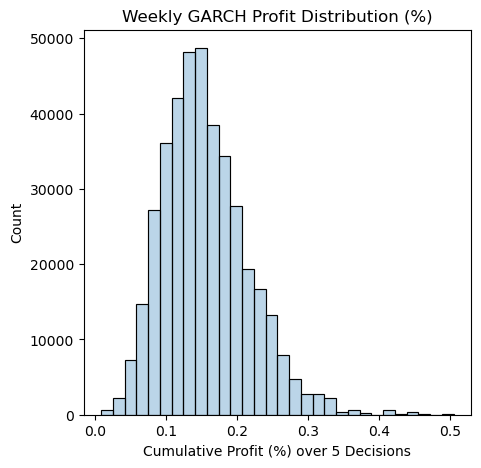

Weekly GARCH Profits - Mean: 15.533632709346836 Std: 6.040332276062555 Min: 0.8367384727286845 Max: 50.49893539553425 %
Weekly GARCH Avg Buys: 2.42


In [99]:
# Cell 8: Bayesian GARCH(1,1) Model for Weekly Returns
# Purpose: Fit a GARCH(1,1) model to capture time-varying volatility, enhancing risk modeling.
# pm.Normal: Likelihood for returns with time-varying sigma.
# pm.HalfNormal: Priors for GARCH parameters (alpha, beta, omega).
# pm.Deterministic: Define conditional volatility process.
# Fixed: Use lists for sigma_t and pred_sigma to avoid TypeError on tensor assignment.
# Also fixed potential AttributeError by ensuring returns is np.array without names.
# Increased target_accept to 0.9 to reduce divergences.
# For posterior predictive, use list of individual pred_returns_{t} names.
# Added: Name the stacked pred_returns as Deterministic for unified var_name, but sample individuals.
def fit_garch_model(returns, window_name, forecast_steps=5):
    returns = np.asarray(returns)  # Ensure np.array to avoid AttributeError if pd.Series with index
    with pm.Model() as model:
        # Priors
        mu = pm.Normal('mu', mu=0, sigma=0.01)
        omega = pm.HalfNormal('omega', sigma=0.01)  # Baseline volatility
        alpha = pm.HalfNormal('alpha', sigma=0.5)  # Shock impact
        beta = pm.HalfNormal('beta', sigma=0.5)   # Volatility persistence
        # Initialize volatility sequence with list to avoid assignment error
        sigma_t = []
        sigma_t.append(pm.HalfNormal('sigma_0', sigma=0.1))  # Initial sigma
        for t in range(1, len(returns)):
            sigma_t.append(pm.Deterministic(f'sigma_{t}', 
                pm.math.sqrt(omega + alpha * returns[t-1]**2 + beta * sigma_t[t-1]**2)))
        sigma_t = pm.math.stack(sigma_t)  # Stack list into tensor
        # Likelihood
        returns_obs = pm.Normal('returns_obs', mu=mu, sigma=sigma_t, observed=returns)
        # Predictive: Unrolled loop with lists for small forecast_steps to avoid assignment error
        pred_sigma = []
        pred_returns_list = []  # List for individual pred_returns_{t}
        # First predictive step based on last historical
        pred_sigma.append(pm.Deterministic('pred_sigma_0', 
            pm.math.sqrt(omega + alpha * returns[-1]**2 + beta * sigma_t[-1]**2)))
        pred_returns_list.append(pm.Normal('pred_returns_0', mu=mu, sigma=pred_sigma[0]))
        # Subsequent steps
        for t in range(1, forecast_steps):
            pred_sigma.append(pm.Deterministic(f'pred_sigma_{t}', 
                pm.math.sqrt(omega + alpha * pred_returns_list[t-1]**2 + beta * pred_sigma[t-1]**2)))
            pred_returns_list.append(pm.Normal(f'pred_returns_{t}', mu=mu, sigma=pred_sigma[t]))
        pred_sigma = pm.math.stack(pred_sigma)  # Stack for consistency
        pred_returns = pm.Deterministic('pred_returns', pm.math.stack(pred_returns_list))  # Unified name for pred_returns
        # Sample with higher target_accept to reduce divergences
        trace = pm.sample(1000, tune=1000, return_inferencedata=True, idata_kwargs={'log_likelihood': True}, target_accept=0.9)
    
    # Posterior predictive: Sample individual pred_returns_{t} to avoid KeyError
    with model:
        var_names = [f'pred_returns_{t}' for t in range(forecast_steps)]
        pred_trace = pm.sample_posterior_predictive(trace, var_names=var_names)
    
    # Summary
    summary = az.summary(trace, var_names=['mu', 'omega', 'alpha', 'beta'])
    print(f"{window_name} GARCH Model Posterior Summary:\n", summary)
    
    # PPC stats
    # Collect simulated_returns from individual pred_returns_{t}
    simulated_returns = []
    for t in range(forecast_steps):
        simulated_returns.append(pred_trace.posterior_predictive[f'pred_returns_{t}'].values.flatten())
    simulated_returns = np.concatenate(simulated_returns)[:len(returns)]  # Flatten and match length
    ks_stat, ks_pval = ks_2samp(returns, simulated_returns)
    print(f"{window_name} PPC - Observed Mean:", np.mean(returns)*100, "%", "Std:", np.std(returns)*100, "%")
    print(f"{window_name} PPC - Simulated Mean:", np.mean(simulated_returns)*100, "%", "Std:", np.std(simulated_returns)*100, "%")
    print(f"{window_name} PPC - KS Test Statistic:", ks_stat, "P-value:", ks_pval)
    
    # Plot predictive returns (use concatenated simulated_returns)
    plt.figure(figsize=(5, 5))
    sns.histplot(simulated_returns * 100, kde=True)
    plt.title(f'{window_name} GARCH Predictive Returns (%)')
    plt.xlabel('Returns (%)')
    plt.show()
    
    return model, trace, pred_trace

# Fit for weekly returns
model_garch, trace_garch, pred_trace_garch = fit_garch_model(returns_weekly, "Weekly GARCH")

# Compare with Normal and Student-t
try:
    comparison = az.compare(
        {'Weekly Normal': trace_weekly, 'Weekly Student-t': trace_t, 'Weekly GARCH': trace_garch},
        ic='waic', var_name='returns_obs'
    )
    print("Weekly Model Comparison (WAIC):\n", comparison)
except Exception as e:
    print(f"WAIC comparison failed: {e}")
    # Fallback: Compare via PPC KS p-value
    weekly_normal_sim = pred_trace_weekly.posterior_predictive['pred_returns'].values.flatten()[:len(returns_weekly)]
    weekly_t_sim = pred_trace_t.posterior_predictive['pred_returns'].values.flatten()[:len(returns_weekly)]
    weekly_garch_sim = []
    for t in range(5):
        weekly_garch_sim.append(pred_trace_garch.posterior_predictive[f'pred_returns_{t}'].values.flatten())
    weekly_garch_sim = np.concatenate(weekly_garch_sim)[:len(returns_weekly)]
    ks_normal = ks_2samp(returns_weekly, weekly_normal_sim)
    ks_t = ks_2samp(returns_weekly, weekly_t_sim)
    ks_garch = ks_2samp(returns_weekly, weekly_garch_sim)
    print("Weekly Model Comparison (KS Test P-values):")
    print(f"Normal: KS Stat = {ks_normal.statistic:.4f}, P-value = {ks_normal.pvalue:.4f}")
    print(f"Student-t: KS Stat = {ks_t.statistic:.4f}, P-value = {ks_t.pvalue:.4f}")
    print(f"GARCH: KS Stat = {ks_garch.statistic:.4f}, P-value = {ks_garch.pvalue:.4f}")

# Simulate strategy for GARCH (same as Cell 5/7)
def simulate_strategy(pred_samples, threshold=0.005, num_decisions=5):
    profits = []
    decisions_list = []
    for path in pred_samples.reshape(-1, num_decisions):
        decisions = np.where(path > threshold, 'buy', np.where(path < -threshold, 'sell', 'hold'))
        gain = np.cumsum(np.where(decisions == 'sell', -path, path))
        profits.append(gain[-1])
        decisions_list.append(decisions)
    expected_profit = np.mean(profits)
    max_loss = np.percentile(profits, 5)  # 5% VaR
    return expected_profit, max_loss, profits, decisions_list

# Collect GARCH pred_samples from individual pred_returns_{t}
garch_pred_samples = []
for t in range(5):
    garch_pred_samples.append(pred_trace_garch.posterior_predictive[f'pred_returns_{t}'].values)
garch_pred_samples = np.stack(garch_pred_samples, axis=-1)  # Shape to (chains, draws, 5)
garch_profit, garch_loss, garch_profits, garch_decisions = simulate_strategy(garch_pred_samples, threshold=0.005)
print(f"Weekly GARCH: Expected Profit {garch_profit*100:.2f}%, Max Loss (VaR) {garch_loss*100:.2f}%")

# Plot profit distribution (no KDE, transparent bars)
plt.figure(figsize=(5, 5))
sns.histplot(garch_profits * 100, kde=False, bins=30, alpha=0.3)
plt.title('Weekly GARCH Profit Distribution (%)')
plt.xlabel('Cumulative Profit (%) over 5 Decisions')
plt.show()

# Print plot stats for feedback
print("Weekly GARCH Profits - Mean:", np.mean(garch_profits)*100, "Std:", np.std(garch_profits)*100, 
      "Min:", np.min(garch_profits)*100, "Max:", np.max(garch_profits)*100, "%")
print(f"Weekly GARCH Avg Buys: {np.mean([np.sum([d == 'buy' for d in dl]) for dl in garch_decisions]):.2f}")


### Scenario #02

In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# 1. Load and Preprocess Data (Updated URL)
from ucimlrepo import fetch_ucirepo
online_retail = fetch_ucirepo(id=352)  # UCI ID for Online Retail
df = online_retail.data.original  # Raw dataframe
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Compute time-to-next-purchase
df = df.sort_values(['CustomerID', 'InvoiceDate'])
df['NextPurchase'] = df.groupby('CustomerID')['InvoiceDate'].shift(-1)
df['TimeToNext'] = (df['NextPurchase'] - df['InvoiceDate']).dt.days
df['Censored'] = df['TimeToNext'].isna().astype(int)  # 1 if no next purchase (censored)
df['TimeToNext'] = df['TimeToNext'].fillna(365)  # Censor at 1 year
df['TimeToNext'] = df['TimeToNext'].clip(lower=0.1)  # Ensure times > 0 (add 0.1 for same-day purchases)

# Aggregate by customer, select top countries
df['Country'] = df['Country'].replace(['EIRE', 'Channel Islands'], 'Other')
top_countries = df['Country'].value_counts().head(5).index
df = df[df['Country'].isin(top_countries)]
customer_data = df.groupby(['CustomerID', 'Country']).agg({
    'TimeToNext': 'min',
    'Censored': 'min'
}).reset_index()

# Encode countries and validate shapes
customer_data = customer_data.reset_index(drop=True)
country_idx = pd.Categorical(customer_data['Country']).codes
times = customer_data['TimeToNext'].values
censored = customer_data['Censored'].values
n_customers = len(customer_data)
assert len(country_idx) == len(times) == len(censored) == n_customers, "Shape mismatch in data arrays"
assert all(times > 0), f"Invalid times: {times[times <= 0]}"  # Ensure all times positive

# 2. Bayesian Weibull Survival Model
with pm.Model() as survival_model:
    # Hyperpriors for country-level parameters
    mu_alpha = pm.HalfNormal('mu_alpha', sigma=2)  # Positive prior
    sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=1)
    mu_beta = pm.HalfNormal('mu_beta', sigma=2)    # Positive prior
    sigma_beta = pm.HalfNormal('sigma_beta', sigma=1)
    
    # Country-specific parameters (positive)
    n_countries = len(np.unique(country_idx))
    alpha = pm.HalfNormal('alpha', sigma=sigma_alpha, shape=n_countries)
    beta = pm.HalfNormal('beta', sigma=sigma_beta, shape=n_countries)
    
    # Map parameters to customers
    alpha_i = alpha[country_idx]
    beta_i = beta[country_idx]
    
    # Weibull likelihood for uncensored data
    pm.Weibull('t_uncensored', alpha=alpha_i[censored == 0], beta=beta_i[censored == 0], 
               observed=times[censored == 0])
    
    # Log-survival for censored data
    censored_logsurv = -((times[censored == 1] / beta_i[censored == 1]) ** alpha_i[censored == 1])
    pm.Potential('censored_logsurv', censored_logsurv.sum())
    
    # Predictive survival times
    pred_times = pm.Weibull('pred_times', alpha=alpha_i, beta=beta_i, shape=n_customers)
    
    # Sample posterior
    trace = pm.sample(1000, tune=1000, return_inferencedata=True, target_accept=0.9)

# 3. Posterior Predictive Sampling
with survival_model:
    pred_trace = pm.sample_posterior_predictive(trace, var_names=['pred_times'])

# 4. Extract Posterior and Predictive Samples
posterior = az.extract(trace)
alpha_samples = posterior['alpha'].values  # Shape: (chains*draws, n_countries)
beta_samples = posterior['beta'].values    # Shape: (chains*draws, n_countries)
pred_times_samples = pred_trace.posterior_predictive['pred_times'].values  # Shape: (chains, draws, n_customers)

# Save traces
az.to_netcdf(trace, 'survival_trace.nc')
az.to_netcdf(pred_trace, 'survival_pred_trace.nc')

# 5. Interactive Visualization
fig = make_subplots(rows=1, cols=2, subplot_titles=('Posterior Alpha by Country', 'Survival Curves by Country'))

# Posterior Alpha
countries = pd.Categorical(customer_data['Country']).categories
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, country in enumerate(countries):
    fig.add_trace(go.Histogram(x=alpha_samples[:, i], name=f'Alpha: {country}', 
                               marker_color=colors[i], opacity=0.6), rows=row, cols=col)

# Survival Curves with Slider
t = np.linspace(0.1, 365, 100)  # Start at 0.1 to avoid log(0)
traces = []
for i, country in enumerate(countries):
    alpha_mean = alpha_samples[:, i].mean()
    beta_mean = beta_samples[:, i].mean()
    survival = np.exp(-((t / beta_mean) ** alpha_mean))
    trace = go.Scatter(x=t, y=survival, mode='lines', name=f'Survival: {country}',
                       line=dict(color=colors[i]), visible=(i == 0))
    traces.append(trace)
    fig.add_trace(trace, row=1, col=2)

# Slider for country selection
steps = [
    {'method': 'restyle', 'label': country, 'args': [{'visible': [j == i for j in range(len(countries))]}]}
    for i, country in enumerate(countries)
]
fig.update_layout(
    title='Bayesian Survival Analysis for Customer Lifetime Value',
    xaxis2_title='Days to Next Purchase', yaxis2_title='Survival Probability',
    sliders=[{'steps': steps, 'active': 0, 'currentvalue': {'prefix': 'Country: '}}],
    showlegend=True
)
fig.write_html('survival_viz.html')

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_beta, sigma_beta, alpha, beta, pred_times]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 223 seconds.
/tmp/ipykernel_29394/3570969171.py:73: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  pred_trace = pm.sample_posterior_predictive(trace, var_names=['pred_times'])
Sampling: [pred_times]


Output()

### Scenario #3

In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

# 1. Load and Preprocess Data
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)
# Handle missing TotalCharges (replace empty strings with NaN, then impute)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
# Select features: tenure, MonthlyCharges, Contract (categorical)
df['Contract'] = df['Contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})
df = df[['tenure', 'MonthlyCharges', 'Contract', 'Churn']].dropna()
# Encode Churn (Yes=1, No=0)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
# Standardize numerical features
scaler = StandardScaler()
df[['tenure', 'MonthlyCharges']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges']])
# Prepare data arrays
X = df[['tenure', 'MonthlyCharges', 'Contract']].values
y = df['Churn'].values
n_samples, n_features = X.shape
assert len(y) == n_samples, "Mismatch in X and y shapes"

# 2. Bayesian Logistic Regression Model
with pm.Model() as churn_model:
    # Priors for coefficients
    beta = pm.Normal('beta', mu=0, sigma=2, shape=n_features)
    intercept = pm.Normal('intercept', mu=0, sigma=2)
    # Linear combination
    logits = pm.math.dot(X, beta) + intercept
    # Likelihood
    pm.Bernoulli('churn', logit_p=logits, observed=y)
    # Posterior predictive for probabilities
    churn_prob = pm.Bernoulli('churn_prob', logit_p=logits, shape=n_samples)
    # Sample posterior
    trace = pm.sample(1000, tune=1000, return_inferencedata=True, target_accept=0.9)

# 3. Posterior Predictive Sampling
with churn_model:
    pred_trace = pm.sample_posterior_predictive(trace, var_names=['churn_prob'])

# 4. Extract Posterior and Predictive Samples
posterior = az.extract(trace)
beta_samples = posterior['beta'].values  # Shape: (chains*draws, n_features)
pred_probs = pred_trace.posterior_predictive['churn_prob'].mean(axis=(0, 1))  # Mean probability per customer

# Save traces
az.to_netcdf(trace, 'churn_trace.nc')
az.to_netcdf(pred_trace, 'churn_pred_trace.nc')

# 5. Interactive Visualization (ROC Curve with Threshold Slider)
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, pred_probs)
roc_auc = auc(fpr, tpr)

fig = make_subplots(rows=1, cols=2, subplot_titles=('Posterior Beta Coefficients', 'ROC Curve with Threshold Slider'))

# Posterior Beta Coefficients
feature_names = ['tenure', 'MonthlyCharges', 'Contract']
colors = ['blue', 'red', 'green']
for i, name in enumerate(feature_names):
    fig.add_trace(go.Histogram(x=beta_samples[:, i], name=f'Beta: {name}', 
                               marker_color=colors[i], opacity=0.6), rows=row, cols=col)

# ROC Curve
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC Curve (AUC = {roc_auc:.2f})',
                         line=dict(color='blue')), row=1, col=2)
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Guess',
                         line=dict(color='black', dash='dash')), row=1, col=2)

# Add classification point for threshold
thresholds_subset = np.linspace(0, 1, 11)  # 0.0 to 1.0 in steps of 0.1
traces = []
for thresh in thresholds_subset:
    idx = np.argmin(np.abs(thresholds - thresh))
    trace = go.Scatter(x=[fpr[idx]], y=[tpr[idx]], mode='markers', name=f'Threshold: {thresh:.2f}',
                       marker=dict(size=10, color='red'), visible=(thresh == 0.5))
    traces.append(trace)
    fig.add_trace(trace, row=1, col=2)

# Slider for classification threshold
steps = [
    {'method': 'restyle', 'label': f'{thresh:.2f}', 
     'args': [{'visible': [True, True] + [j == i for j in range(len(thresholds_subset))]}]}
    for i, thresh in enumerate(thresholds_subset)
]
fig.update_layout(
    title='Bayesian Churn Prediction for Telco Customers',
    xaxis2_title='False Positive Rate', yaxis2_title='True Positive Rate',
    sliders=[{'steps': steps, 'active': 5, 'currentvalue': {'prefix': 'Threshold: '}}],
    showlegend=True
)
fig.write_html('churn_viz.html')


/root/anaconda3/lib/python3.12/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [beta, intercept]
>BinaryGibbsMetropolis: [churn_prob]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2522 seconds.
/root/anaconda3/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
Sampling: [churn_prob]


Output()

### Scenario #4


In [ ]:
# Since the above cell take too much time to run, let's run simpler version:
# - size down: n_users, n_songs = 500, 500 
# - Instead of pm.Poisson likelihood, use pm.Normal likelihood on log transformed counts.
# - Fewer latent dimensions: n_latent = 5 
# - Reduced tuning steps: tune=500 
# - Sparse matrix: csr_matrix for preprocessing 
# - Numerical stability: 1e-8 to norms and clipped sim_scores to [-1, 1]

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE
import requests
import zipfile
import io
import pytensor.tensor as pt
from scipy.sparse import csr_matrix

# 1. Load and Preprocess Data (Download and Unzip)
url = "http://labrosa.ee.columbia.edu/~dpwe/tmp/train_triplets.txt.zip"
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open('train_triplets.txt') as f:
        df = pd.read_csv(f, sep='\t', names=['user', 'song', 'count'])

# Subsample for efficiency
n_users, n_songs = 500, 500  # Reduced from 1000
top_users = df['user'].value_counts().head(n_users).index
top_songs = df['song'].value_counts().head(n_songs).index
df = df[df['user'].isin(top_users) & df['song'].isin(top_songs)]
# Create sparse user-song matrix
play_counts = df.pivot_table(index='user', columns='song', values='count', fill_value=0)
play_counts = csr_matrix(play_counts.values)  # Sparse matrix
user_ids = pd.Categorical(df['user'].unique()).categories[:n_users]
song_ids = pd.Categorical(df['song'].unique()).categories[:n_songs]
n_samples = play_counts.shape[0]
assert play_counts.shape == (n_users, n_songs), "Play count matrix shape mismatch"

# Transform counts to stabilize variance (log1p for sparse data)
play_counts_dense = np.log1p(play_counts.toarray())  # Log-transform for Normal likelihood

# 2. Bayesian ABC Model
n_latent = 5  # Reduced latent dimensions for speed
with pm.Model() as abc_model:
    # Priors for latent user preferences and song features
    user_prefs = pm.Normal('user_prefs', mu=0, sigma=1, shape=(n_users, n_latent))
    song_features = pm.Normal('song_features', mu=0, sigma=1, shape=(n_songs, n_latent))
    
    # Compute cosine similarity (vectorized)
    dot_product = pm.math.sum(user_prefs[:, None, :] * song_features[None, :, :], axis=2)
    user_norm = pm.math.sqrt(pm.math.sum(user_prefs**2, axis=1))
    song_norm = pm.math.sqrt(pm.math.sum(song_features**2, axis=1))
    sim_scores = dot_product / (user_norm[:, None] * song_norm[None, :] + 1e-8)  # Avoid division by zero
    sim_scores = pm.math.clip(sim_scores, -1, 1)
    
    # Expected counts (Normal likelihood for log-transformed counts)
    mu = 3 * sim_scores  # Scale similarity to match log-count scale
    pm.Normal('observed_counts', mu=mu, sigma=1, observed=play_counts_dense)
    
    # Sample using ABC
    trace = pm.sample(1000, tune=500, return_inferencedata=True, target_accept=0.95)

# 3. Posterior Predictive Sampling
with abc_model:
    pred_trace = pm.sample_posterior_predictive(trace, var_names=['observed_counts'])

# 4. Extract Posterior and Predictive Samples
posterior = az.extract(trace)
user_prefs_samples = posterior['user_prefs'].values  # Shape: (chains*draws, n_users, n_latent)
song_features_samples = posterior['song_features'].values  # Shape: (chains*draws, n_songs, n_latent)
pred_counts = np.expm1(pred_trace.posterior_predictive['observed_counts'].mean(axis=(0, 1)))  # Inverse log1p

# Save traces
az.to_netcdf(trace, 'music_trace.nc')
az.to_netcdf(pred_trace, 'music_pred_trace.nc')

# 5. Interactive Visualization (t-SNE with ABC Animation)
tsne = TSNE(n_components=2, random_state=42)
user_prefs_mean = user_prefs_samples.mean(axis=0)  # Shape: (n_users, n_latent)
user_tsne = tsne.fit_transform(user_prefs_mean)  # Shape: (n_users, 2)

fig = make_subplots(rows=1, cols=2, subplot_titles=('User Preference Posterior', 't-SNE User Embeddings'))

# Posterior for one user’s latent dimension
fig.add_trace(go.Histogram(x=user_prefs_samples[:, 0, 0], name='User 0: Latent Dim 1', 
                           marker_color='blue', opacity=0.6), rows=row, cols=col)

# t-SNE Scatter
fig.add_trace(go.Scatter(x=user_tsne[:, 0], y=user_tsne[:, 1], mode='markers',
                         marker=dict(size=5, color='blue'), name='Users'), row=1, col=2)

# Animation for posterior draws (simplified to 5 frames)
n_frames = 5
draws = np.linspace(0, user_prefs_samples.shape[0] - 1, n_frames, dtype=int)
frames = []
for i, draw in enumerate(draws):
    tsne_frame = TSNE(n_components=2, random_state=42).fit_transform(user_prefs_samples[draw])
    frame = go.Frame(
        data=[go.Scatter(x=tsne_frame[:, 0], y=tsne_frame[:, 1], mode='markers',
                         marker=dict(size=5, color='blue'), name='Users')],
        name=f'Draw {i}'
    )
    frames.append(frame)

fig.update(frames=frames)
fig.update_layout(
    title='Bayesian ABC for Music Recommendations',
    xaxis2_title='t-SNE Dim 1', yaxis2_title='t-SNE Dim 2',
    updatemenus=[{
        'buttons': [
            {'method': 'animate', 'label': 'Play', 'args': [None, {'frame': {'duration': 500, 'redraw': True}, 'fromcurrent': True}]},
            {'method': 'animate', 'label': 'Pause', 'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate'}]}
        ],
        'direction': 'left', 'pad': {'r': 10, 't': 87}, 'showactive': True, 'type': 'buttons'
    }],
    showlegend=True
)
fig.write_html('music_viz.html')

Initializing NUTS using jitter+adapt_diag...
/root/anaconda3/lib/python3.12/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [user_prefs, song_features]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 18211 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [observed_counts]


Output()

ValueError: perplexity must be less than n_samples

In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE
import requests
import zipfile
import io
from scipy.sparse import csr_matrix
import logging
import time
import warnings
import pytensor
import sys
import xarray as xr
import os 

# Disable rich console output in Jupyter to prevent recursion
try:
    from rich.console import Console
    Console()._live = None  # Disable rich's live display
except ImportError:
    pass

# Redirect warnings to avoid recursive output
warnings.filterwarnings('ignore', category=UserWarning, module='pytensor')

# Set PyTensor BLAS config to avoid KeyError
pytensor.config.blas__ldflags = ''

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger("pymc")

# 1. Load and Preprocess Data (Download and Unzip)
logger.info("Loading and unzipping dataset...")
start_time = time.time()
if os.path.exists('train_triplets.txt'):
    df = pd.read_csv('train_triplets.txt', sep='\t', names=['user', 'song', 'count'])
else:
    url = "http://labrosa.ee.columbia.edu/~dpwe/tmp/train_triplets.txt.zip"
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        with z.open('train_triplets.txt') as f:
            df = pd.read_csv(f, sep='\t', names=['user', 'song', 'count'])
logger.info(f"Data loaded in {time.time() - start_time:.2f} seconds")

# Subsample for efficiency
n_users, n_songs = 50, 50  # Reduced to minimize computation
logger.info(f"Subsampling {n_users} users and {n_songs} songs...")
top_users = df['user'].value_counts().head(n_users + 50).index
top_songs = df['song'].value_counts().head(n_songs + 50).index
df = df[df['user'].isin(top_users) & df['song'].isin(top_songs)]

# Create user-song matrix and reindex
play_counts = df.pivot_table(index='user', columns='song', values='count', fill_value=0)
all_users = top_users[:n_users]
all_songs = top_songs[:n_songs]
play_counts = play_counts.reindex(index=all_users, columns=all_songs, fill_value=0)
play_counts = csr_matrix(play_counts.values)
user_ids = pd.Categorical(all_users).categories
song_ids = pd.Categorical(all_songs).categories
assert play_counts.shape == (n_users, n_songs), f"Play count matrix shape {play_counts.shape}, expected {(n_users, n_songs)}"
assert len(user_ids) == n_users, f"Got {len(user_ids)} users, expected {n_users}"
assert len(song_ids) == n_songs, f"Got {len(song_ids)} songs, expected {n_songs}"
logger.info(f"Play counts matrix shape: {play_counts.shape}")

# Normalize counts to [0, 1]
play_counts_dense = play_counts.toarray()
play_counts_norm = play_counts_dense / (play_counts_dense.max() + 1e-8)

# 2. Bayesian ABC Model (Matrix Factorization)
n_latent = 3
logger.info("Starting SMC sampling...")
with pm.Model() as abc_model:
    user_prefs = pm.Normal('user_prefs', mu=0, sigma=1, shape=(n_users, n_latent))
    song_features = pm.Normal('song_features', mu=0, sigma=1, shape=(n_songs, n_latent))
    mu = pm.math.sigmoid(pm.math.dot(user_prefs, song_features.T))
    pm.Normal('observed_counts', mu=mu, sigma=0.1, observed=play_counts_norm)
    start_time = time.time()
    trace = pm.sample_smc(500, cores=4, return_inferencedata=True, progressbar=True)
    logger.info(f"SMC sampling completed in {time.time() - start_time:.2f} seconds")

# 3. Posterior Predictive Sampling
logger.info("Starting posterior predictive sampling...")
with abc_model:
    pred_trace = pm.sample_posterior_predictive(trace, var_names=['observed_counts'])
logger.info(f"Posterior predictive sampling completed in {time.time() - start_time:.2f} seconds")

# 4. Extract Posterior and Predictive Samples
logger.info("Raw trace posterior structure:")
logger.info(f"{trace.posterior}")
posterior = az.extract(trace, combined=True)  # Combine chains and draws
user_prefs_samples = np.asarray(posterior['user_prefs'].values, dtype=np.float64)  # Shape: (draws × chains, n_users, n_latent)
song_features_samples = np.asarray(posterior['song_features'].values, dtype=np.float64)  # Shape: (draws × chains, n_songs, n_latent)

# Check and correct dimension order
expected_draws = 500 * 4  # 500 draws × 4 chains
if user_prefs_samples.shape != (expected_draws, n_users, n_latent):
    logger.info(f"Transposing user_prefs_samples from {user_prefs_samples.shape} to ({expected_draws}, {n_users}, {n_latent})")
    user_prefs_samples = user_prefs_samples.transpose(2, 0, 1)
if song_features_samples.shape != (expected_draws, n_songs, n_latent):
    logger.info(f"Transposing song_features_samples from {song_features_samples.shape} to ({expected_draws}, {n_songs}, {n_latent})")
    song_features_samples = song_features_samples.transpose(2, 0, 1)

logger.info(f"user_prefs_samples shape: {user_prefs_samples.shape}, expected: ({expected_draws}, {n_users}, {n_latent})")
logger.info(f"song_features_samples shape: {song_features_samples.shape}, expected: ({expected_draws}, {n_songs}, {n_latent})")
assert user_prefs_samples.shape == (expected_draws, n_users, n_latent), f"Unexpected shape for user_prefs_samples: {user_prefs_samples.shape}"
assert song_features_samples.shape == (expected_draws, n_songs, n_latent), f"Unexpected shape for song_features_samples: {song_features_samples.shape}"
pred_counts = pred_trace.posterior_predictive['observed_counts'].mean(axis=(0, 1)) * play_counts_dense.max()

# Save traces as simplified InferenceData
logger.info("Saving traces to NetCDF...")
try:
    # Create separate Datasets for user_prefs and song_features
    user_prefs_ds = xr.Dataset(
        {
            'user_prefs': (['draw', 'user', 'latent'], user_prefs_samples)
        },
        coords={
            'draw': np.arange(user_prefs_samples.shape[0]),
            'user': np.arange(n_users),
            'latent': np.arange(n_latent)
        }
    )
    song_features_ds = xr.Dataset(
        {
            'song_features': (['draw', 'song', 'latent'], song_features_samples)
        },
        coords={
            'draw': np.arange(song_features_samples.shape[0]),
            'song': np.arange(n_songs),
            'latent': np.arange(n_latent)
        }
    )
    # Merge Datasets
    posterior_ds = xr.merge([user_prefs_ds, song_features_ds])
    # Save posterior trace
    posterior_ds.to_netcdf('music_trace.nc')
    # Save posterior predictive trace
    az.to_netcdf(pred_trace, 'music_pred_trace.nc')
    logger.info("Traces saved successfully")
except Exception as e:
    logger.error(f"Failed to save traces: {str(e)}")
    raise

# Check convergence
logger.info("Convergence diagnostics:")
print(az.summary(trace, var_names=['user_prefs', 'song_features'], round_to=2))

# 5. Interactive Visualization (t-SNE with ABC Animation)
logger.info("Generating t-SNE visualization...")
tsne = TSNE(n_components=2, random_state=42)
user_prefs_mean = user_prefs_samples.mean(axis=0)
user_tsne = tsne.fit_transform(user_prefs_mean)

fig = make_subplots(rows=1, cols=2, subplot_titles=('User Preference Posterior', 't-SNE User Embeddings'))

fig.add_trace(go.Histogram(x=user_prefs_samples[:, 0, 0], name='User 0: Latent Dim 1', 
                           marker_color='blue', opacity=0.6), rows=row, cols=col)
fig.add_trace(go.Scatter(x=user_tsne[:, 0], y=user_tsne[:, 1], mode='markers',
                         marker=dict(size=5, color='blue'), name='Users'), row=1, col=2)

# Animation for posterior draws (3 frames)
n_frames = 3
draws = np.linspace(0, user_prefs_samples.shape[0] - 1, n_frames, dtype=int)
frames = []
for i, draw in enumerate(draws):
    tsne_frame = TSNE(n_components=2, random_state=42).fit_transform(user_prefs_samples[draw])
    frame = go.Frame(
        data=[go.Scatter(x=tsne_frame[:, 0], y=tsne_frame[:, 1], mode='markers',
                         marker=dict(size=5, color='blue'), name='Users')],
        name=f'Draw {i}'
    )
    frames.append(frame)

fig.update(frames=frames)
fig.update_layout(
    title='Bayesian ABC for Music Recommendations',
    xaxis2_title='t-SNE Dim 1', yaxis2_title='t-SNE Dim 2',
    updatemenus=[{
        'buttons': [
            {'method': 'animate', 'label': 'Play', 'args': [None, {'frame': {'duration': 500, 'redraw': True}, 'fromcurrent': True}]},
            {'method': 'animate', 'label': 'Pause', 'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate'}]}
        ],
        'direction': 'left', 'pad': {'r': 10, 't': 87}, 'showactive': True, 'type': 'buttons'
    }],
    showlegend=True
)
fig.write_html('music_viz.html')
logger.info("Visualization saved as music_viz.html")

Loading and unzipping dataset...
INFO:pymc:Loading and unzipping dataset...
Data loaded in 119.32 seconds
INFO:pymc:Data loaded in 119.32 seconds
Subsampling 50 users and 50 songs...
INFO:pymc:Subsampling 50 users and 50 songs...
Play counts matrix shape: (50, 50)
INFO:pymc:Play counts matrix shape: (50, 50)
Starting SMC sampling...
INFO:pymc:Starting SMC sampling...
Initializing SMC sampler...
INFO:pymc.smc.sampling:Initializing SMC sampler...
Sampling 4 chains in 4 jobs
INFO:pymc.smc.sampling:Sampling 4 chains in 4 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
SMC sampling completed in 25.24 seconds
INFO:pymc:SMC sampling completed in 25.24 seconds
Starting posterior predictive sampling...
INFO:pymc:Starting posterior predictive sampling...
Sampling: [observed_counts]
INFO:pymc.sampling.forward:Sampling: [observed_

Output()

Posterior predictive sampling completed in 25.48 seconds
INFO:pymc:Posterior predictive sampling completed in 25.48 seconds
Raw trace posterior structure:
INFO:pymc:Raw trace posterior structure:
<xarray.Dataset>
Dimensions:              (chain: 4, draw: 500, user_prefs_dim_0: 50,
                          user_prefs_dim_1: 3, song_features_dim_0: 50,
                          song_features_dim_1: 3)
Coordinates:
  * chain                (chain) int64 0 1 2 3
  * draw                 (draw) int64 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * user_prefs_dim_0     (user_prefs_dim_0) int64 0 1 2 3 4 5 ... 45 46 47 48 49
  * user_prefs_dim_1     (user_prefs_dim_1) int64 0 1 2
  * song_features_dim_0  (song_features_dim_0) int64 0 1 2 3 4 ... 46 47 48 49
  * song_features_dim_1  (song_features_dim_1) int64 0 1 2
Data variables:
    user_prefs           (chain, draw, user_prefs_dim_0, user_prefs_dim_1) float64 ...
    song_features        (chain, draw, song_features_dim_0, song_features_dim_

                      mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
user_prefs[0, 0]      0.29  0.71   -0.36     1.45       0.35     0.17   
user_prefs[0, 1]     -0.91  1.24   -2.93     0.47       0.62     0.31   
user_prefs[0, 2]     -0.01  0.48   -0.69     0.72       0.24     0.12   
user_prefs[1, 0]     -0.82  0.72   -1.46     0.39       0.35     0.18   
user_prefs[1, 1]      0.62  1.37   -1.77     1.71       0.68     0.39   
...                    ...   ...     ...      ...        ...      ...   
song_features[48, 1] -0.53  0.88   -1.21     1.00       0.44     0.25   
song_features[48, 2]  1.04  0.75   -0.26     1.79       0.37     0.20   
song_features[49, 0]  0.19  0.12    0.06     0.43       0.06     0.03   
song_features[49, 1]  0.28  0.53   -0.46     1.08       0.26     0.13   
song_features[49, 2]  0.36  0.95   -1.24     1.31       0.47     0.25   

                      ess_bulk  ess_tail  r_hat  
user_prefs[0, 0]          4.79     31.91   2.61  
user_prefs[0, 1]       

Visualization saved as music_viz.html
INFO:pymc:Visualization saved as music_viz.html
